# Imports

In [1]:
import os
from pathlib import Path
import numpy as np
from IPython.display import display, HTML, Math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from multispot_utils import heatmap48, spotsh, spotsv
import pybroom as br

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.sans-serif'].insert(0, 'Arial')
plt.rcParams['path.simplify_threshold'] = 1.0
plt.rcParams['font.size'] = 14

In [3]:
from fretbursts import *

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/fretbursts/__init__.py:63: UserWarning:  - Cannot import QT, custom GUI widgets disabled.
  warnings.warn((' - Cannot import QT, custom GUI widgets disabled.'))


 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.7).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [4]:
sns = init_notebook(apionly=True)

In [5]:
plot_timetraces = True

In [6]:
_plot_status = {}

# Load HDF5 files

In [7]:
mlabels = ['-8TA_-3NTD_500pM_no-flow_0-200s', '-8TA_-3NTD_500pM_Streets_chip_with_flow_0-200s']
mlabels

['-8TA_-3NTD_500pM_no-flow_0-200s',
 '-8TA_-3NTD_500pM_Streets_chip_with_flow_0-200s']

In [8]:
dir_ = '.'
dir_ = Path(dir_).absolute()
dir_

PosixPath('/Users/maya/Documents/weiss_lab/48-spot/multispot_review_results')

In [9]:
save_dir = './figures'
Path(save_dir).absolute()

PosixPath('/Users/maya/Documents/weiss_lab/48-spot/multispot_review_results/figures')

In [10]:
ls $dir_

-8TA_-3NTD_500pM_Streets_chip_with_flow_0-200s_background_48-spots_all_streams.png
-8TA_-3NTD_500pM_no-flow_0-200s_-8TA_-3NTD_500pM_Streets_chip_with_flow_0-200s_background_AexDem_AexAem.png
-8TA_-3NTD_500pM_no-flow_0-200s_-8TA_-3NTD_500pM_Streets_chip_with_flow_0-200s_background_DexDem_DexAem.png
-8TA_-3NTD_500pM_no-flow_0-200s_-8TA_-3NTD_500pM_Streets_chip_with_flow_0-200s_interphoton_delay_distribution_nt.png
-8TA_-3NTD_500pM_no-flow_0-200s_background_48-spots_all_streams.png
05_-8TA_-3NTD_500pM.hdf5*
05_-8TA_-3NTD_500pM_cache.hdf5
06_-8TA_-3NTD_500pM_ASchip.hdf5*
06_-8TA_-3NTD_500pM_ASchip_cache.hdf5
README.md
Streets_chip_with_flow_timetrace=1.0-2.0.png
Streets_chip_with_flow_timetrace=100.0-101.0.png
Streets_chip_with_flow_timetrace=149.0-150.0.png
Streets_chip_with_flow_timetrace=198.0-199.0.png
Streets_chip_with_flow_timetrace=50.0-51.0.png
__pycache__/
_config.yml
burst_analysis_for_flow_vs_no-flow_0-200s.ipynb
figures/
metadata/
no_flow_timetrace=1.0-2.0.png
no_flow_timetrace

In [11]:
# sort to have chronological order for repeats
filepaths = sorted([f for f in Path(dir_).glob('*.hdf5') 
                   if 'cache' not in f.stem]) 
fnames = [f.name for f in filepaths]
fnames

['05_-8TA_-3NTD_500pM.hdf5', '06_-8TA_-3NTD_500pM_ASchip.hdf5']

In [12]:
f0 = fnames[0][:19]
f1 = fnames[1][:26]
f0, f1

('05_-8TA_-3NTD_500pM', '06_-8TA_-3NTD_500pM_ASchip')

# Load data

In [13]:
d0 = loader.photon_hdf5(fnames[0])
d1 = loader.photon_hdf5(fnames[1])

In [14]:
blue = '#0055d4'
#navy = '#000080'
green = '#2ca02c'
#limegreen = '#32CD32'
red = '#e74c3c'  # '#E41A1C'
#maroon = '#800000'
purple = '#9b59b6'
#fuschia = '#FF00FF'
cyan = '#00FFFF'
#deepskyblue = '#00BFFF'

In [15]:
def plot_alternation_hist_usalex(d0, d1, bins=None, ax=None, ich0=0, ich1=0, #adding a data object to function
                                 hist_style={}, span_style={}):
    """Plot the us-ALEX alternation histogram for the variable `d`.

    This function must be called on us-ALEX data **before** calling
    :func:`fretbursts.loader.alex_apply_period`.
    """
    if ax is None:
        _, ax = plt.subplots()

    if bins is None:
        bins = 100

    D0_ON, A0_ON = d0._D_ON_multich[ich0], d0._A_ON_multich[ich0]
    D1_ON, A1_ON = d1._D_ON_multich[ich1], d1._A_ON_multich[ich1]
    d0_ch, a0_ch = d0._det_donor_accept_multich[ich0]
    d1_ch, a1_ch = d1._det_donor_accept_multich[ich1]
    offset0 = d0.get('offset', 0)
    offset1 = d1.get('offset', 0)
    
    ph0_times_t, det0_t = d0.ph_times_t[ich0][:], d0.det_t[ich0][:]
    ph1_times_t, det1_t = d1.ph_times_t[ich1][:], d1.det_t[ich1][:]
    period0 = d0.alex_period
    period1 = d1.alex_period
    d0_em_t = (det0_t == d0_ch)
    d1_em_t = (det1_t == d1_ch)
    
    hist_style_ = dict(bins=bins, histtype='step', lw=2, alpha=0.9, zorder=4) #zorder=2
    hist_style_.update(hist_style)
    span_style_ = dict(alpha=0.2, zorder=2) #zorder=1 
    span_style_.update(span_style)

    D0_label = 'Donor: %d-%d, no flow' % (D0_ON[0], D0_ON[1])
    D1_label = 'Donor: %d-%d, Streets chip with 10μL flow rate' % (D1_ON[0], D1_ON[1])
    A0_label = 'Accept: %d-%d, no flow' % (A0_ON[0], A0_ON[1])
    A1_label = 'Accept: %d-%d, Streets chip with 10μL flow rate' % (A1_ON[0], A1_ON[1])

    ax.hist((ph0_times_t[d0_em_t] - offset0) % period0, color=green, label=D0_label,
            **hist_style_)
    ax.hist((ph1_times_t[d1_em_t] - offset1) % period1, color=blue, label=D1_label,
            **hist_style_)
    ax.hist((ph0_times_t[~d0_em_t] - offset0) % period0, color=red, label=A0_label,
            **hist_style_)
    ax.hist((ph1_times_t[~d1_em_t] - offset1) % period1, color=purple, label=A1_label,
            **hist_style_)
    
    ax.set_xlabel('Timestamp MODULO Alternation period')

    if D0_ON[0] < D0_ON[1]:
        ax.axvspan(D0_ON[0], D0_ON[1], color=green, **span_style_)
    else:
        ax.axvspan(0, D0_ON[1], color=green, **span_style_)
        ax.axvspan(D0_ON[0], period0, color=green, **span_style_)
        
    if D1_ON[0] < D1_ON[1]:
        ax.axvspan(D1_ON[0], D1_ON[1], color=green, **span_style_)
    else:
        ax.axvspan(0, D1_ON[1], color=green, **span_style_)
        ax.axvspan(D1_ON[0], period1, color=green, **span_style_)

    if A0_ON[0] < A0_ON[1]:
        ax.axvspan(A0_ON[0], A0_ON[1], color=red, **span_style_)
    else:
        ax.axvspan(0, A0_ON[1], color=red, **span_style_)
        ax.axvspan(A0_ON[0], period0, color=red, **span_style_)
    if A1_ON[0] < A1_ON[1]:
        ax.axvspan(A1_ON[0], A1_ON[1], color=red, **span_style_)
    else:
        ax.axvspan(0, A1_ON[1], color=red, **span_style_)
        ax.axvspan(A1_ON[0], period1, color=red, **span_style_)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

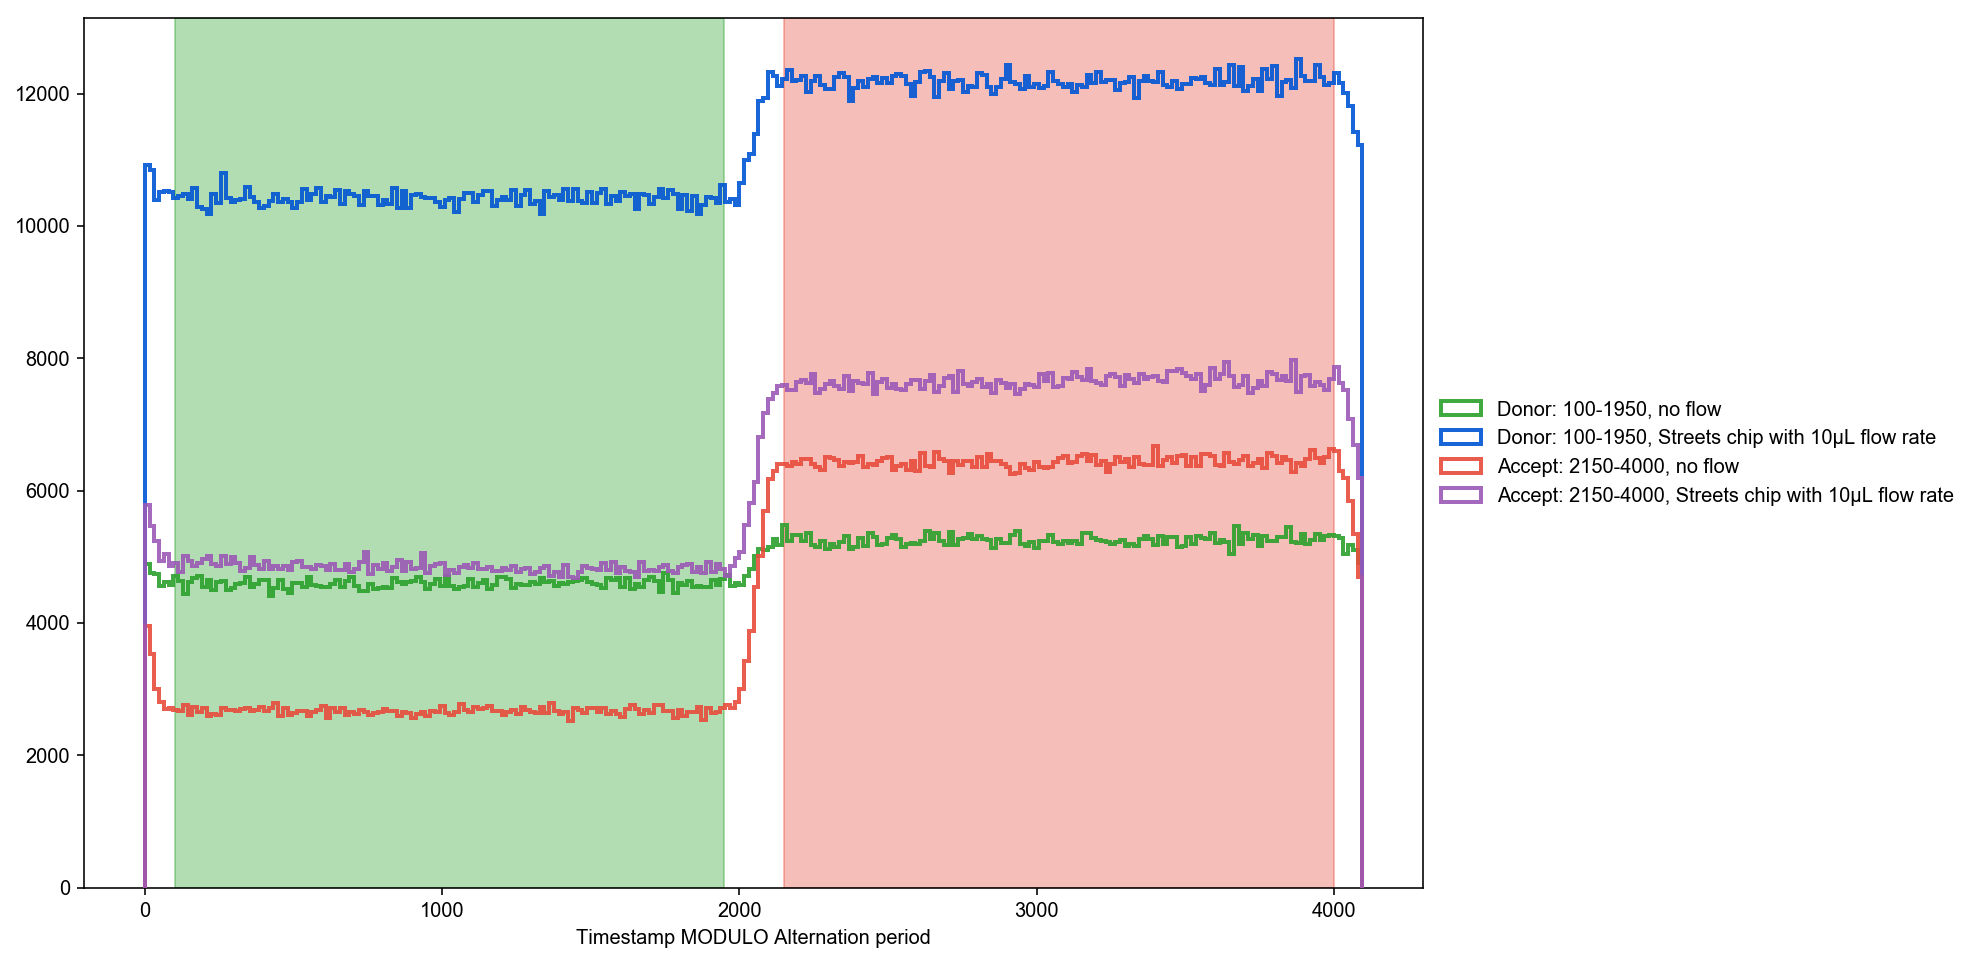

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_alternation_hist_usalex(d0, d1, ax=ax, bins=np.arange(0, 4097, 16))
plt.savefig(f'{save_dir}/{mlabels[0]}_{mlabels[1]}_alternation_hist.png', bbox_inches='tight', dpi=1200);

In [17]:
%%timeit -n1 -r1 
loader.alex_apply_period(d0) 
loader.alex_apply_period(d1)

# Total photons (after ALEX selection):   121,766,143
#  D  photons in D+A excitation periods:   61,895,751
#  A  photons in D+A excitation periods:   59,870,392
# D+A photons in  D  excitation period:    48,825,342
# D+A photons in  A  excitation period:    72,940,801

# Total photons (after ALEX selection):   314,610,922
#  D  photons in D+A excitation periods:  162,968,031
#  A  photons in D+A excitation periods:  151,642,891
# D+A photons in  D  excitation period:    91,730,911
# D+A photons in  A  excitation period:   222,880,011

34 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Select first 0 - 200 s

In [18]:
d0.time_max, d1.time_max

(300.05318665, 300.08232792499996)

In [19]:
d0 = d0.slice_ph(time_s1=0, time_s2=200)
d1 = d1.slice_ph(time_s1=0, time_s2=200)

In [20]:
d0.time_max, d1.time_max

(199.99998507499998, 199.99999778749998)

# Timetraces

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will 

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

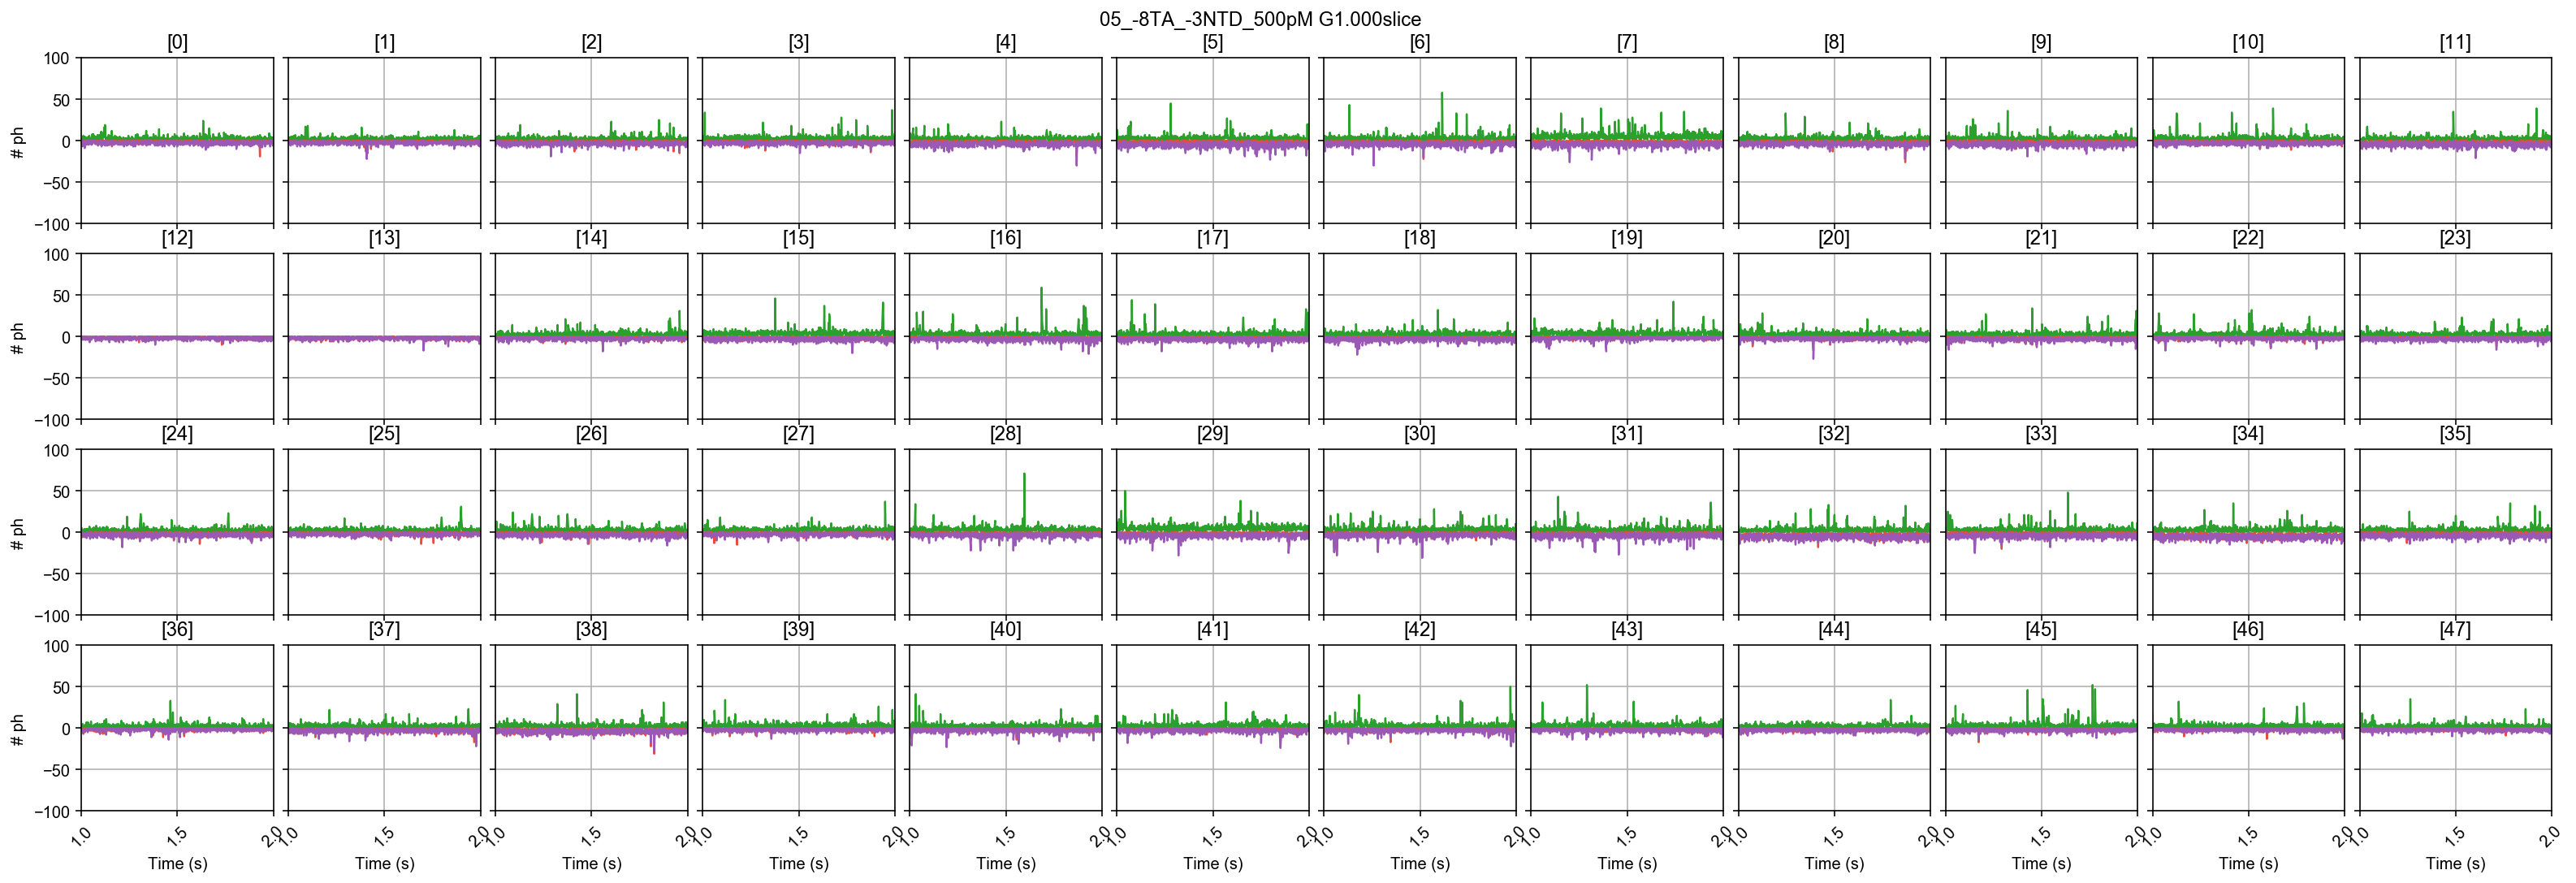

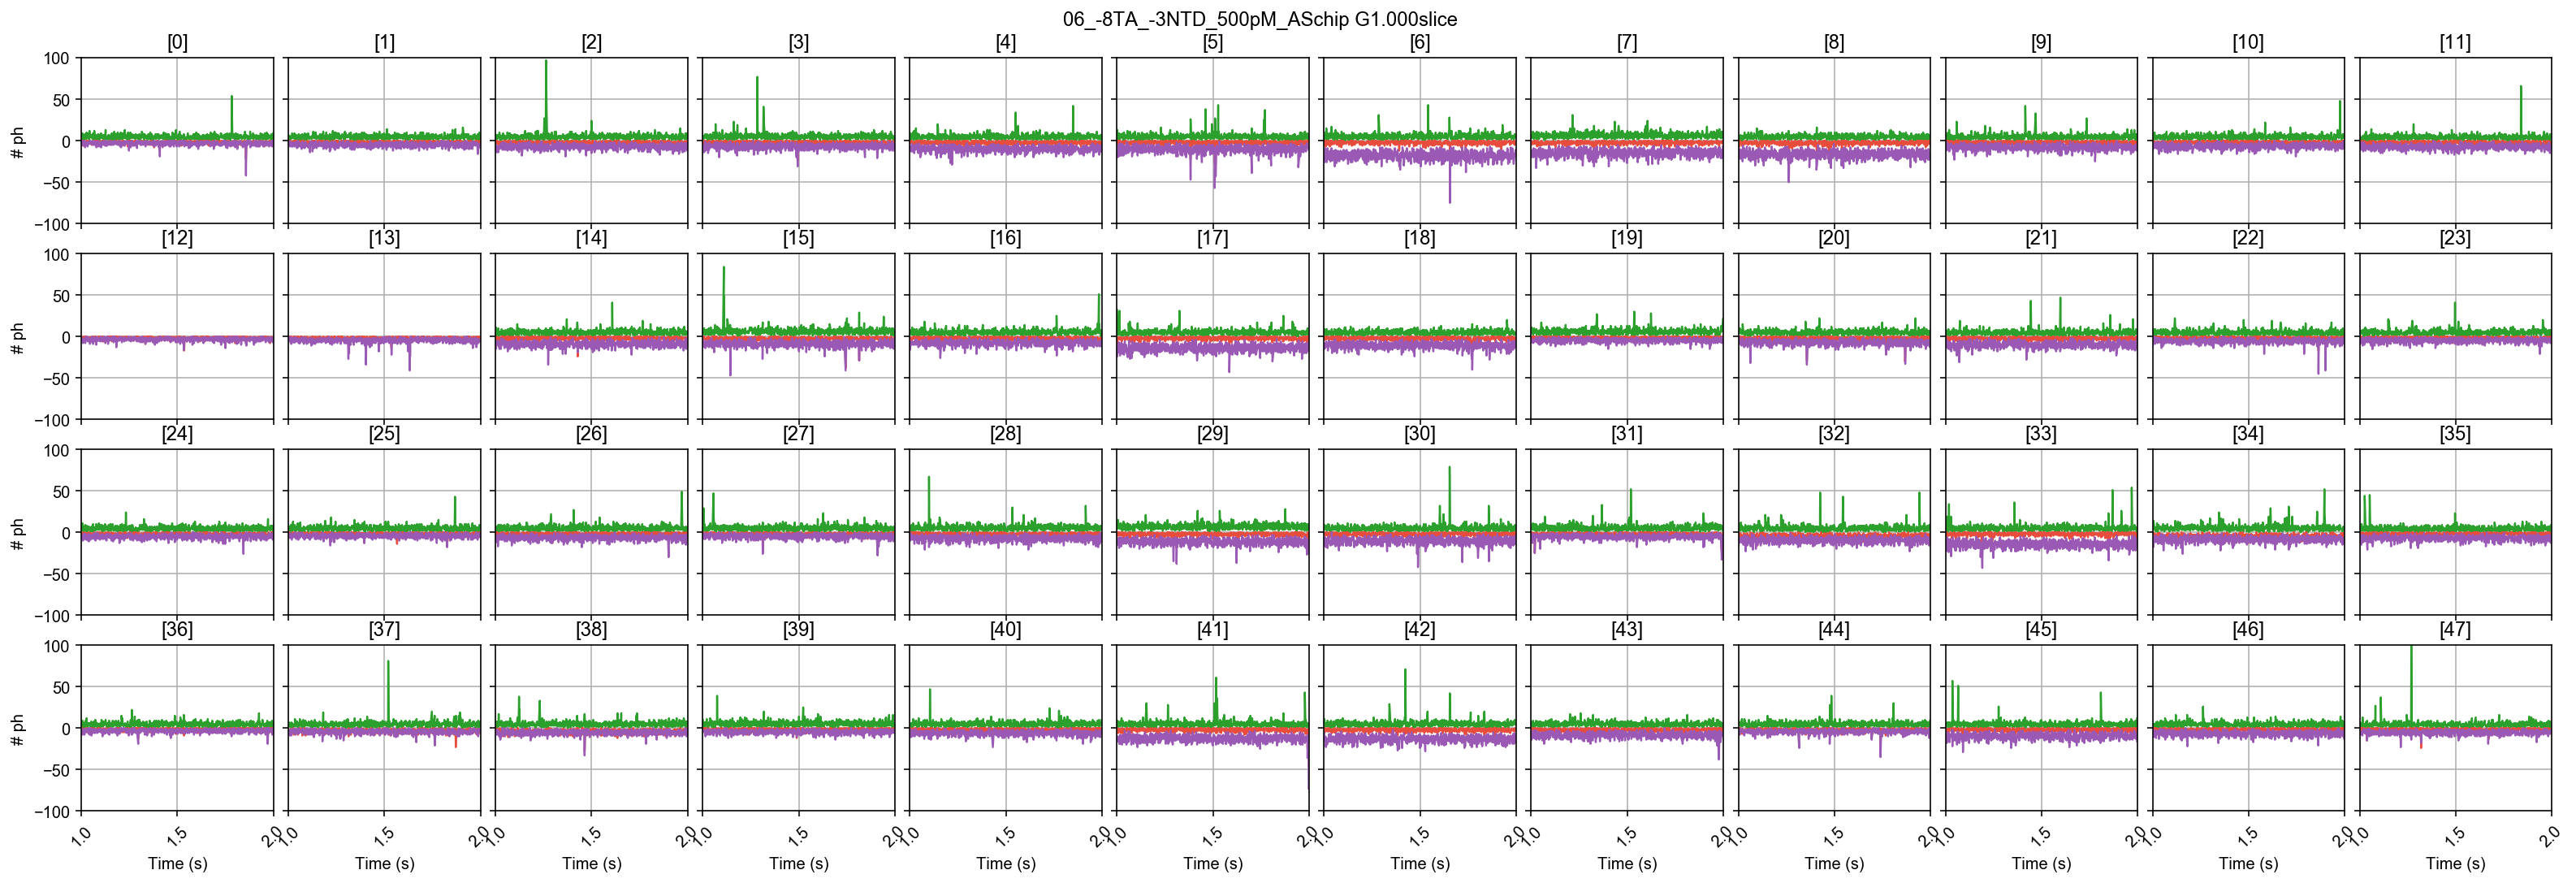

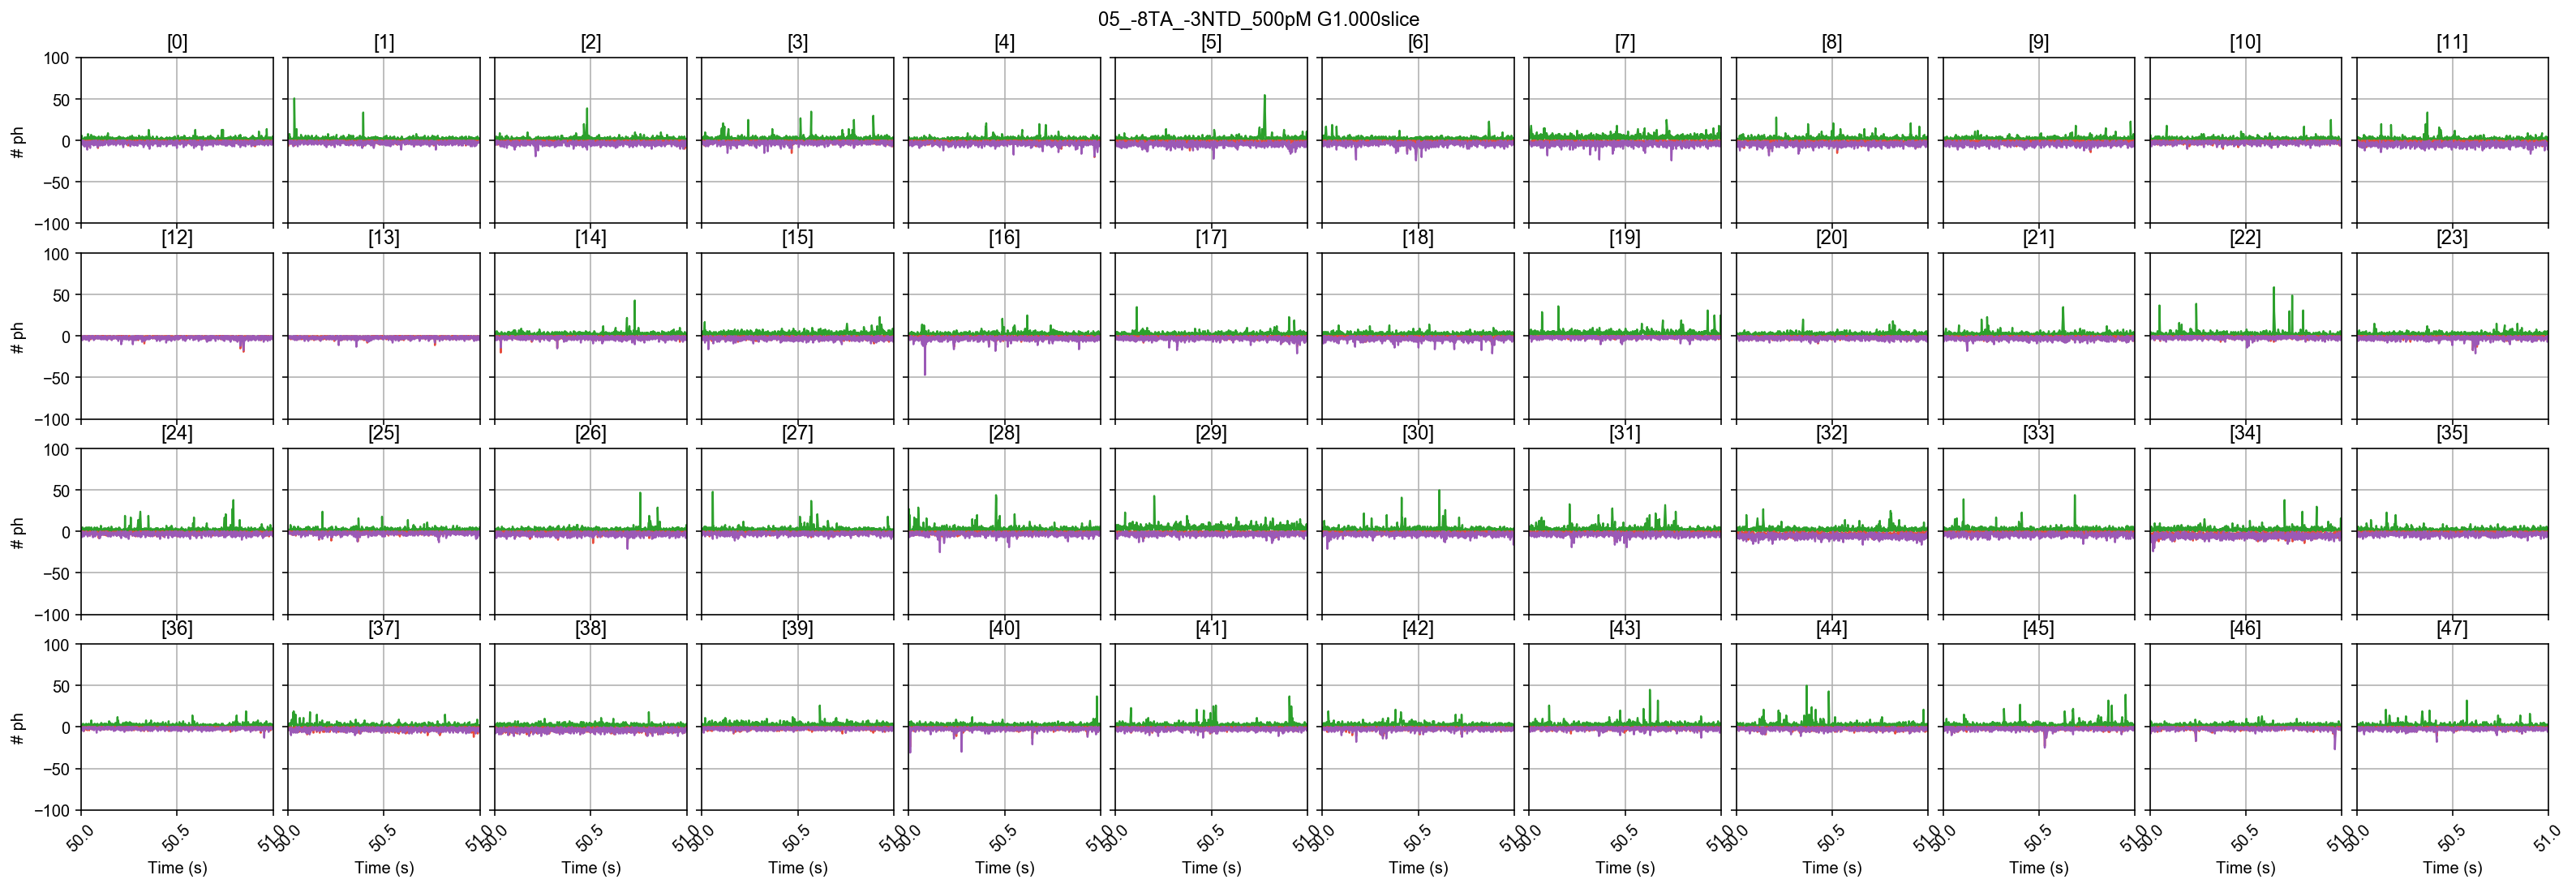

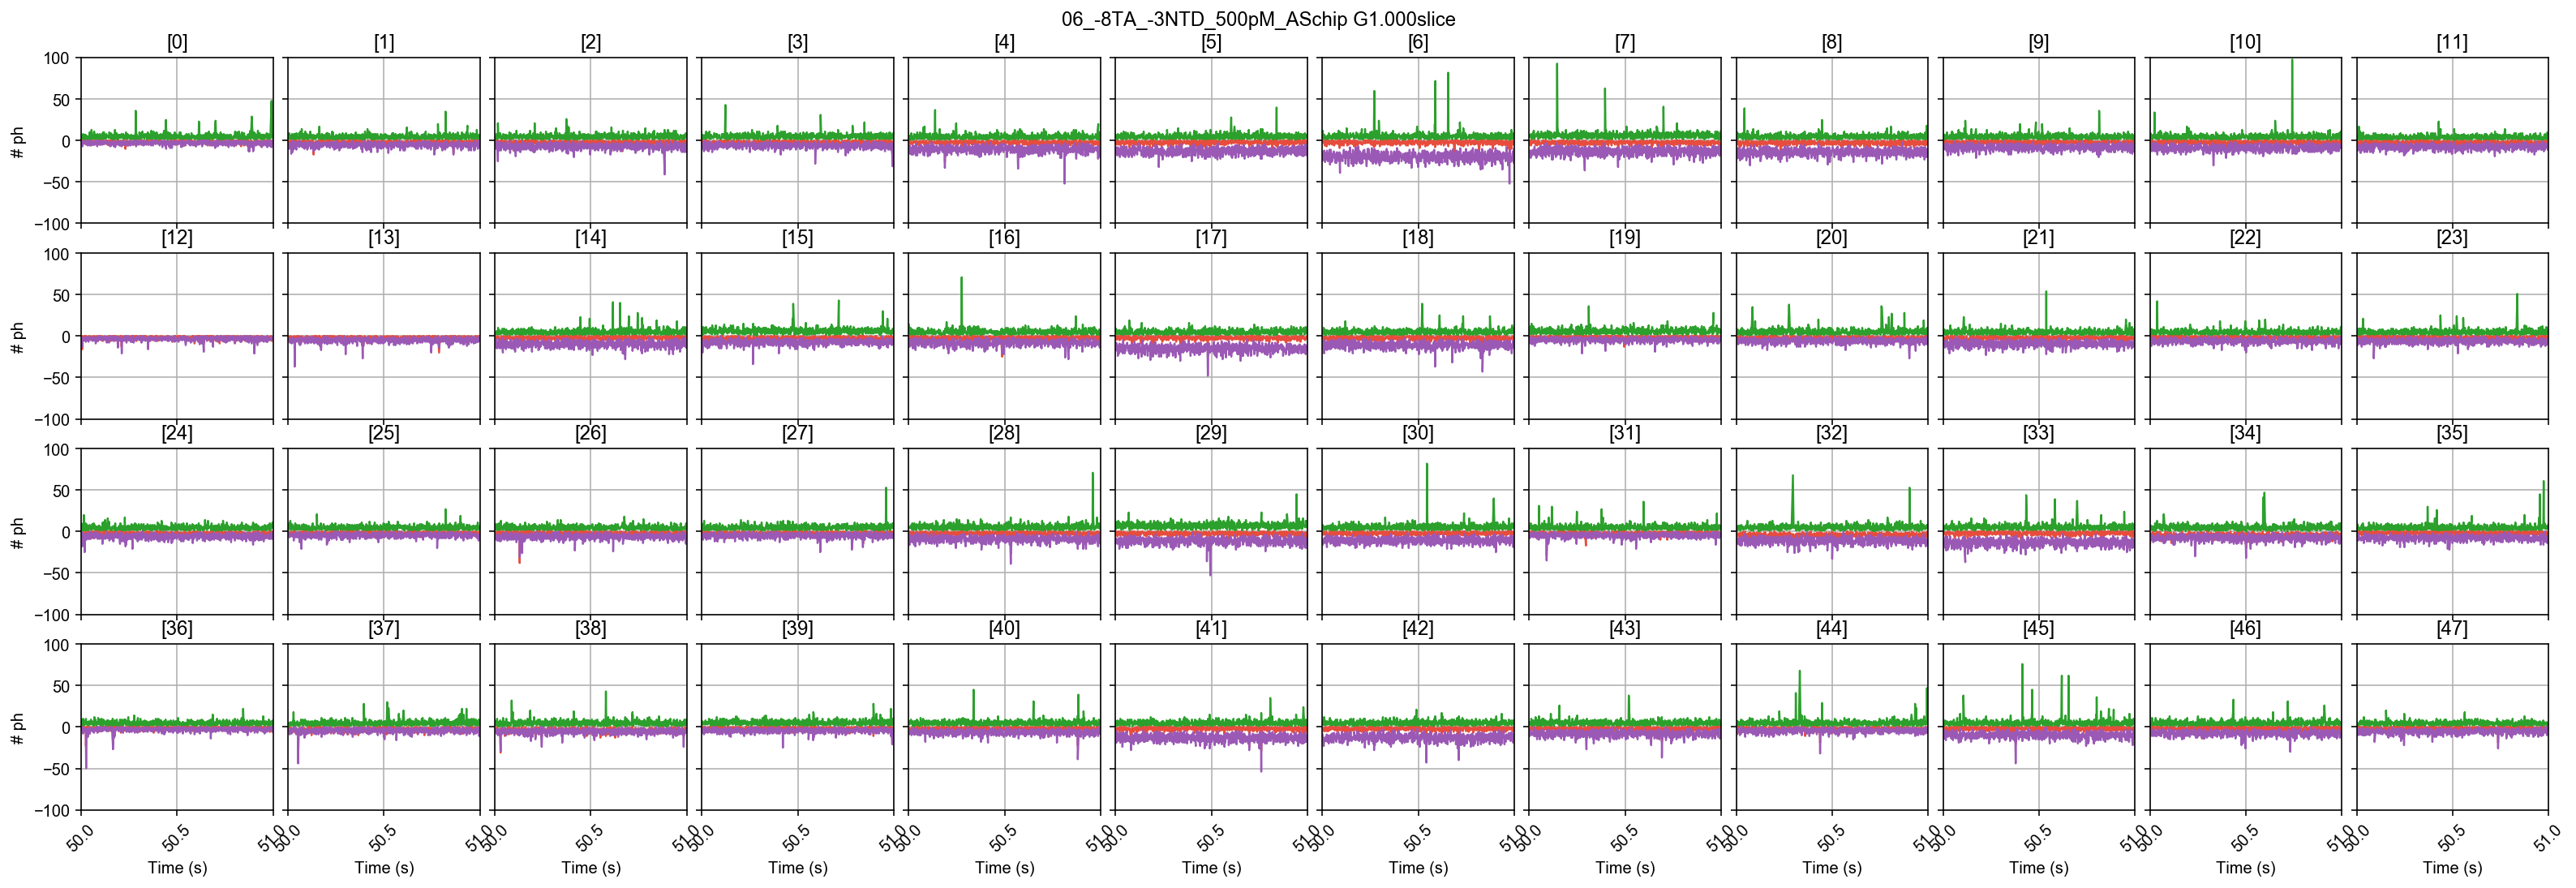

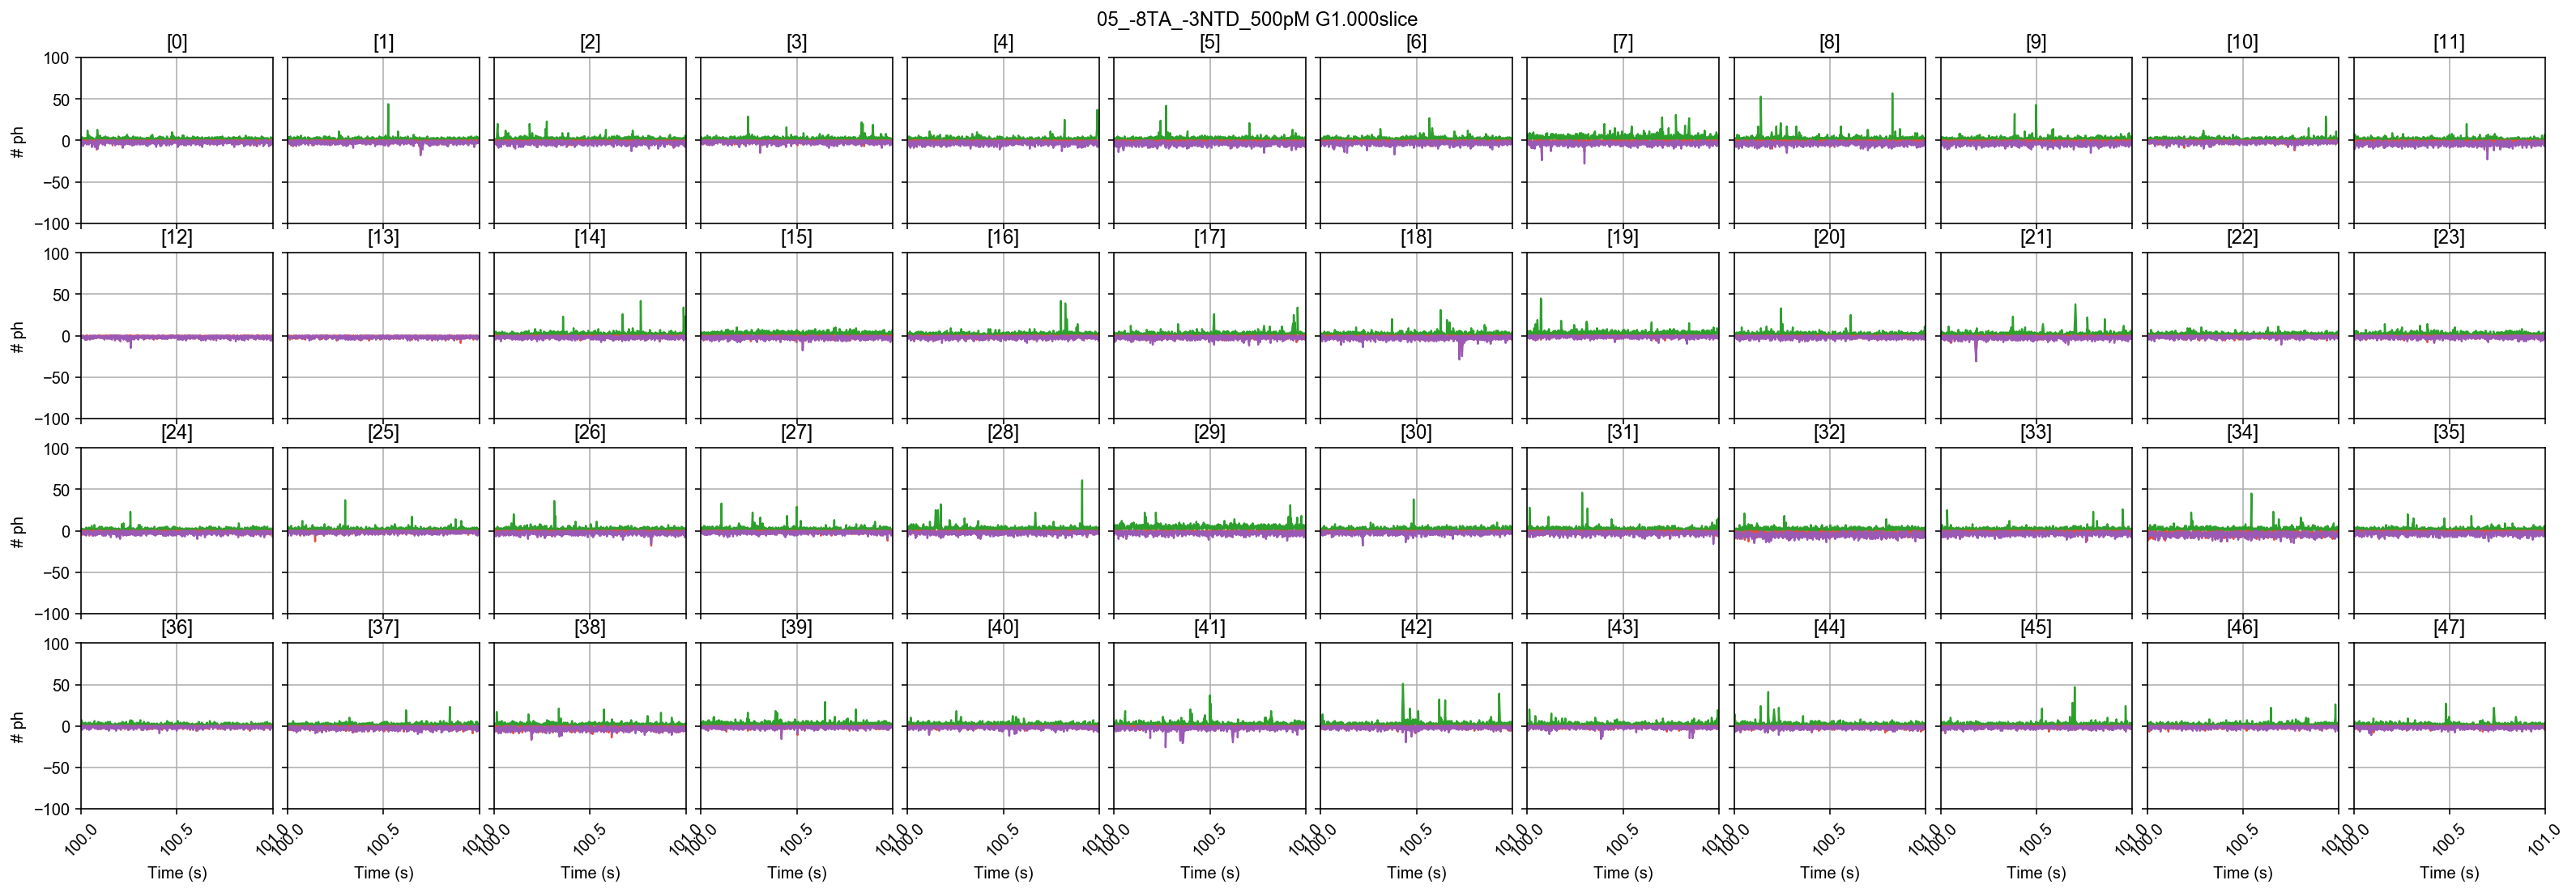

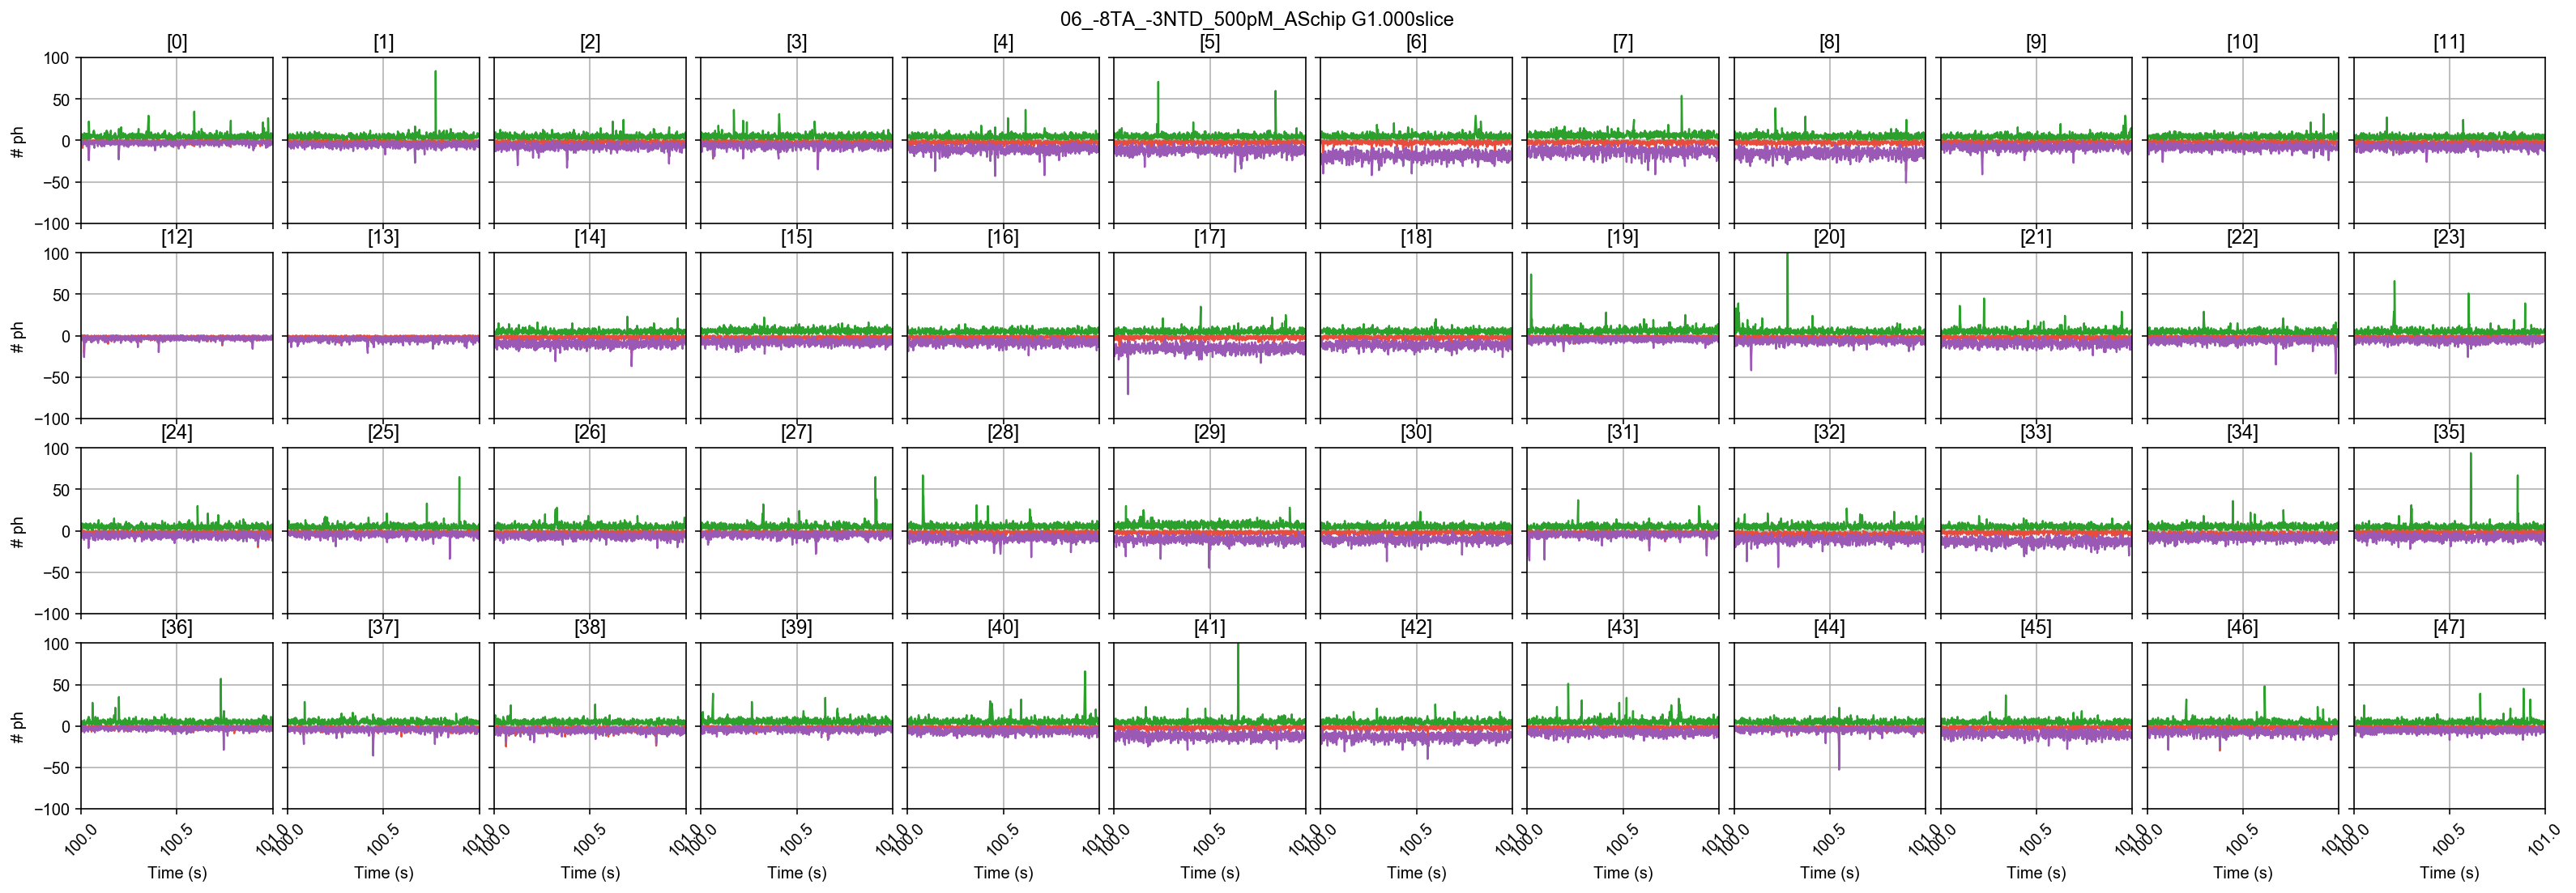

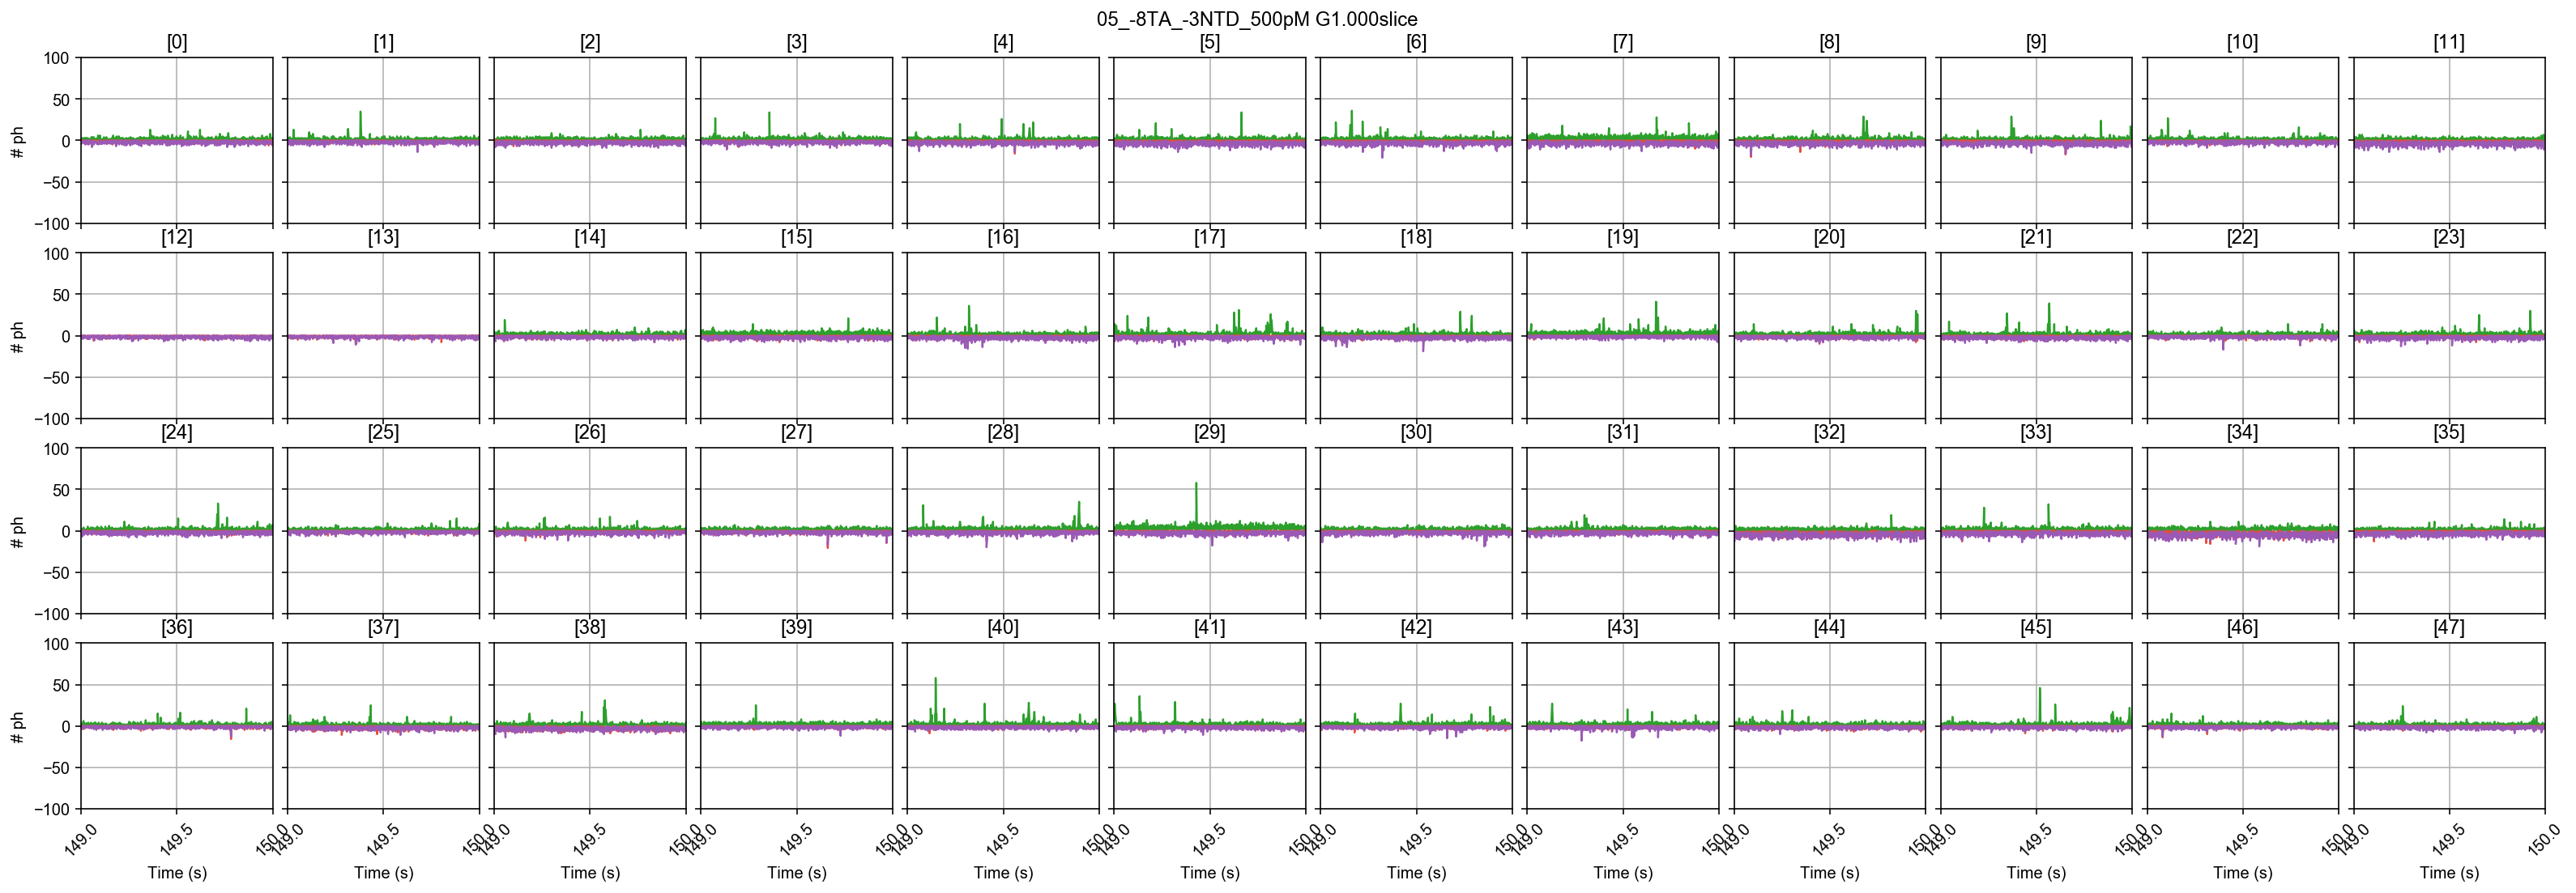

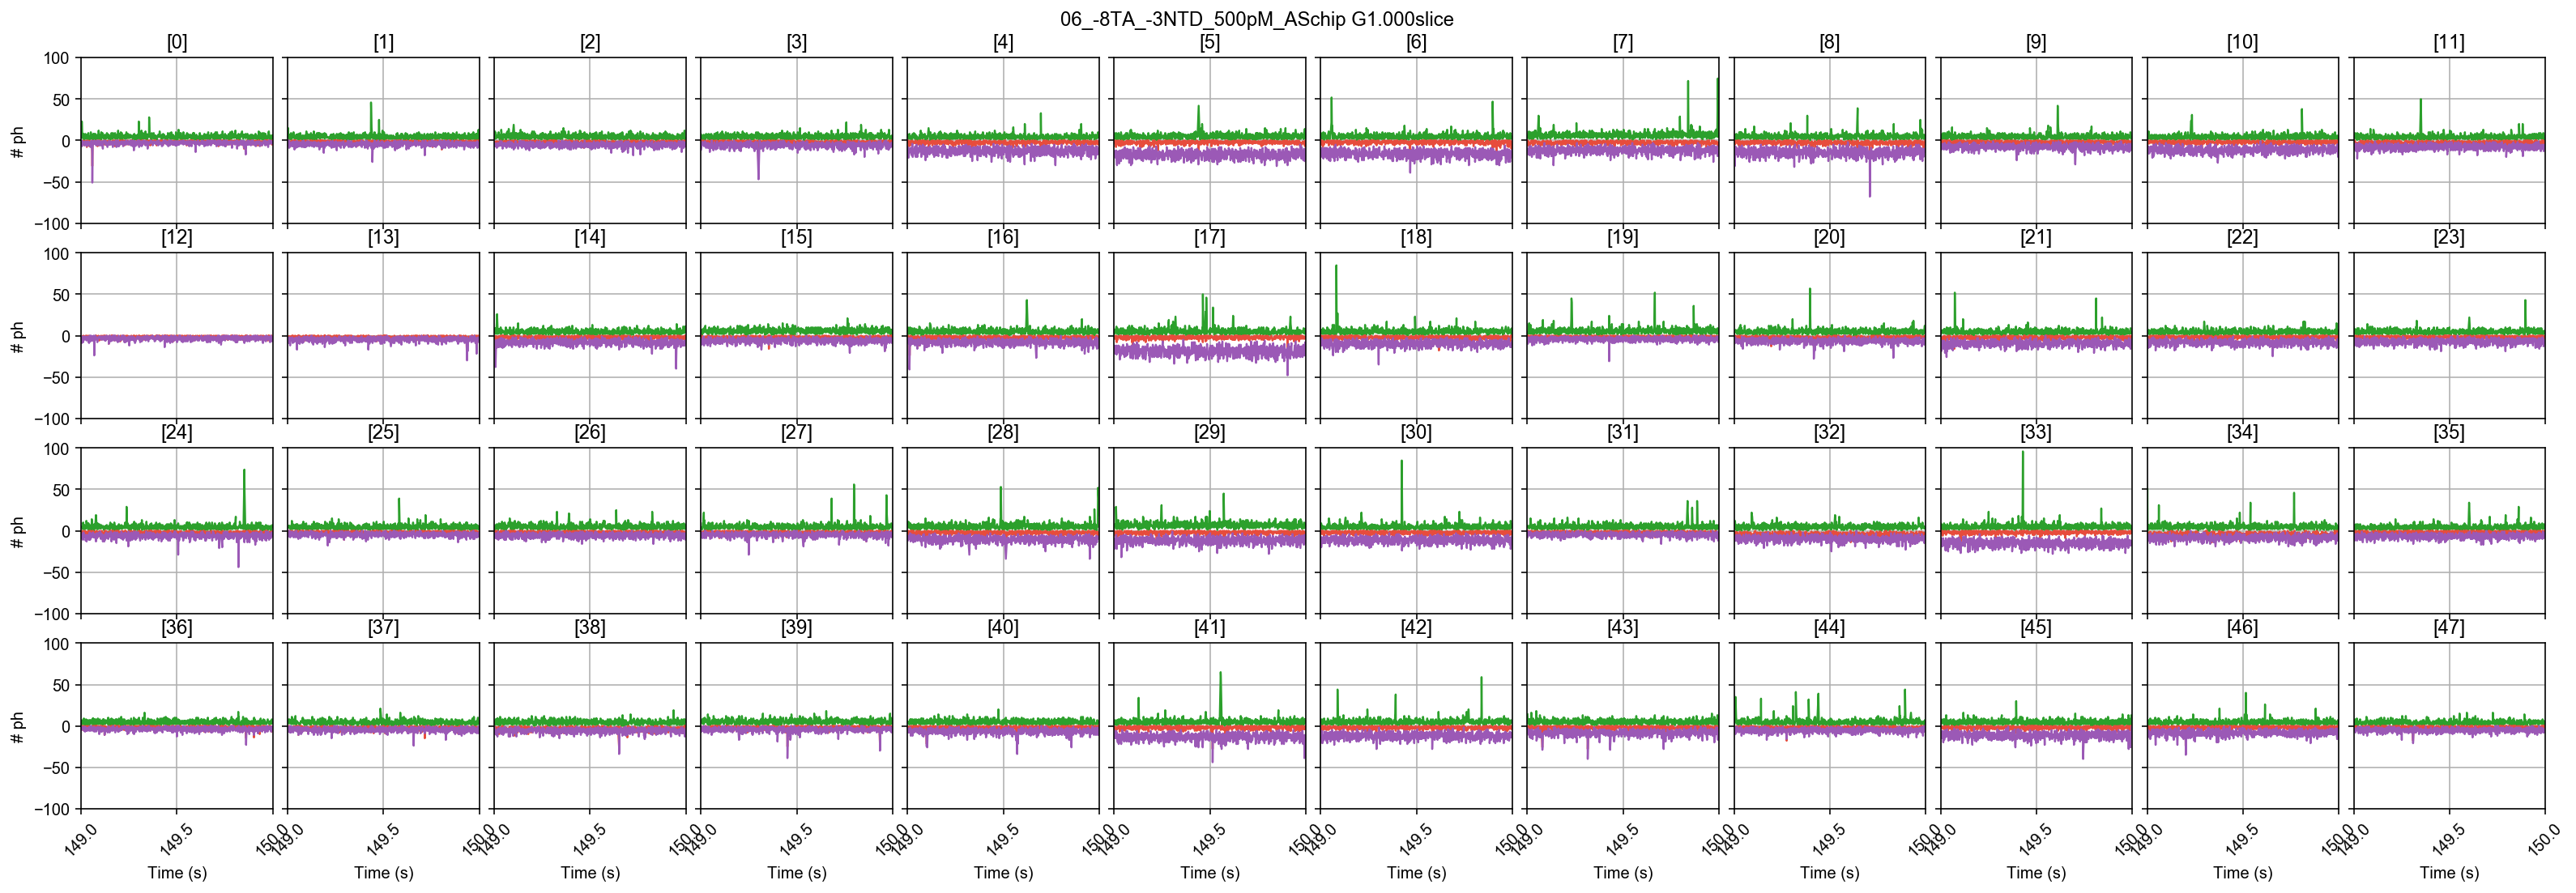

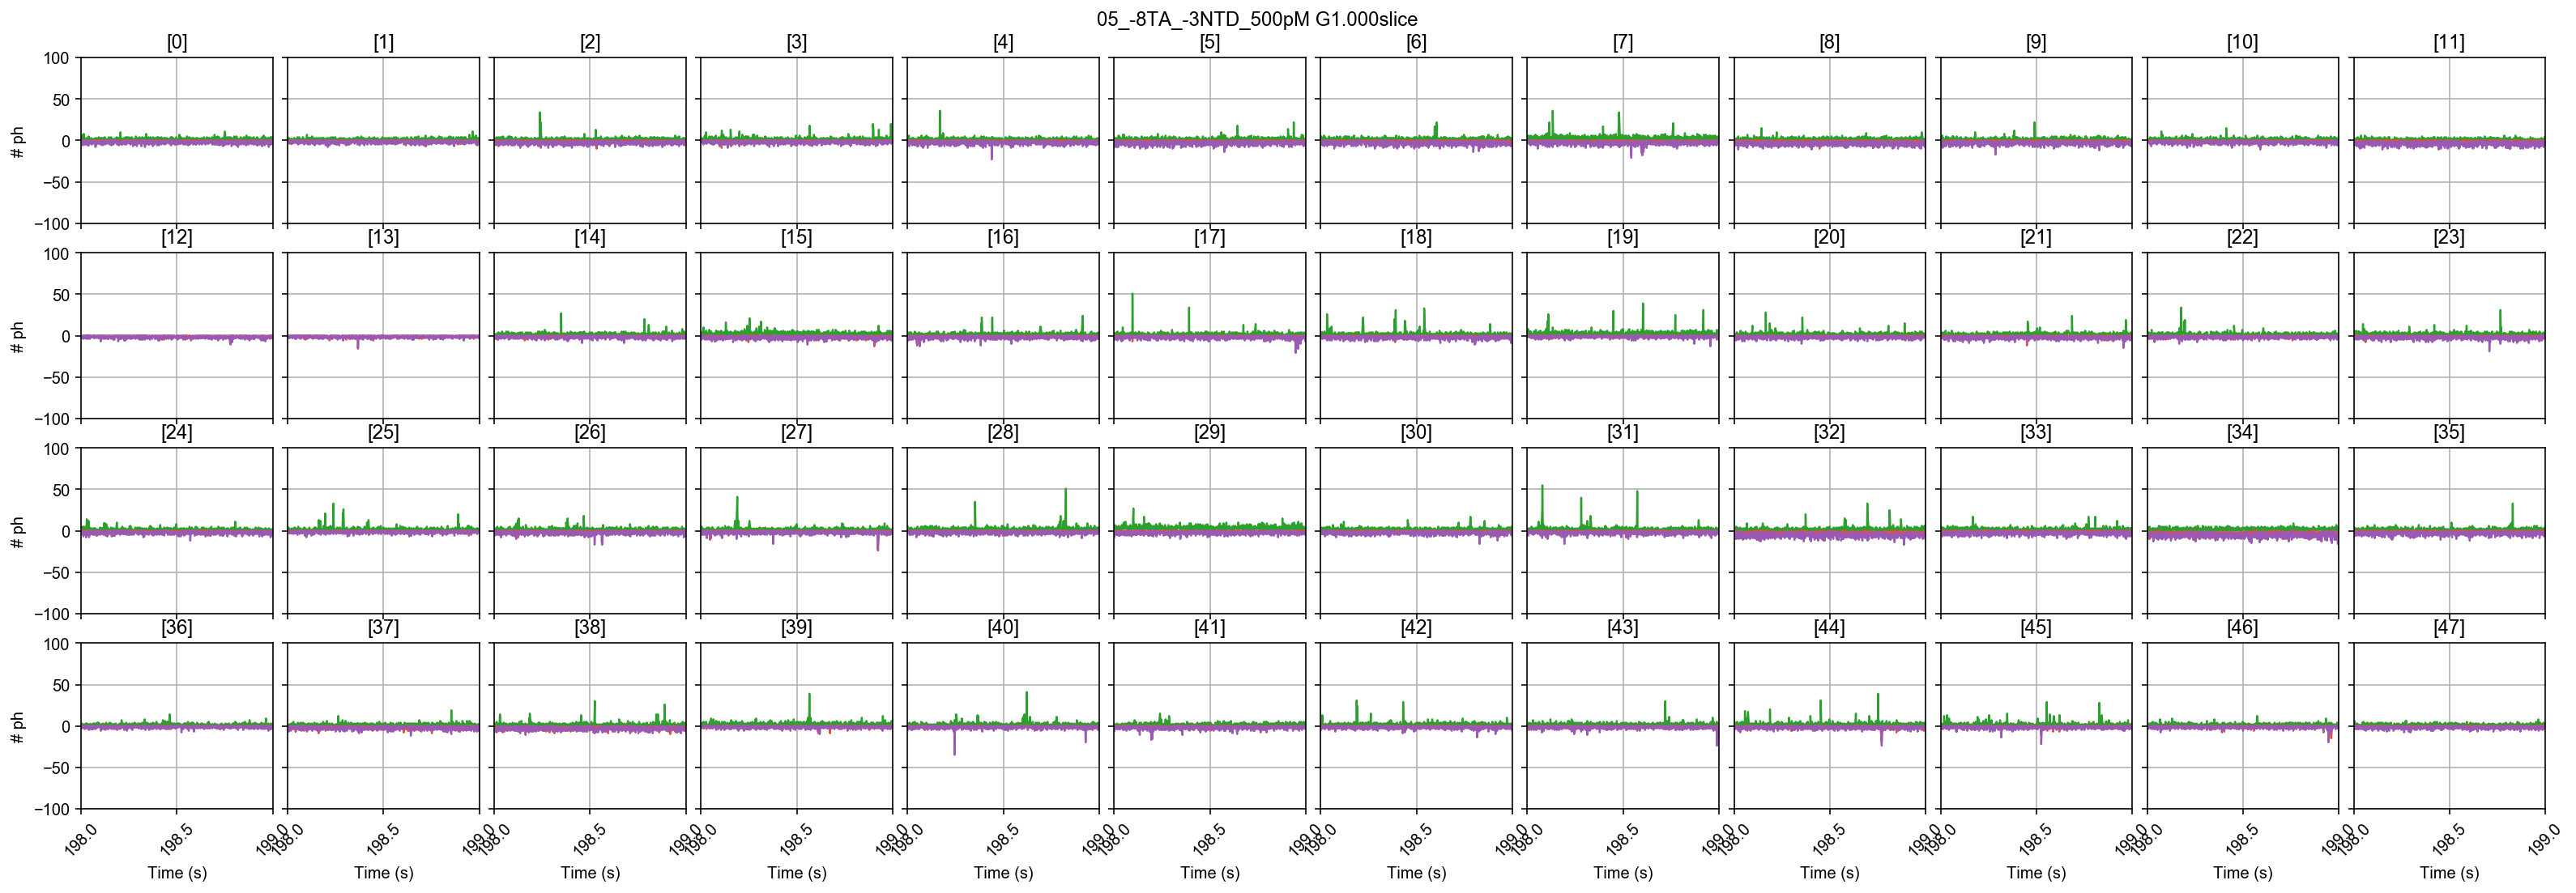

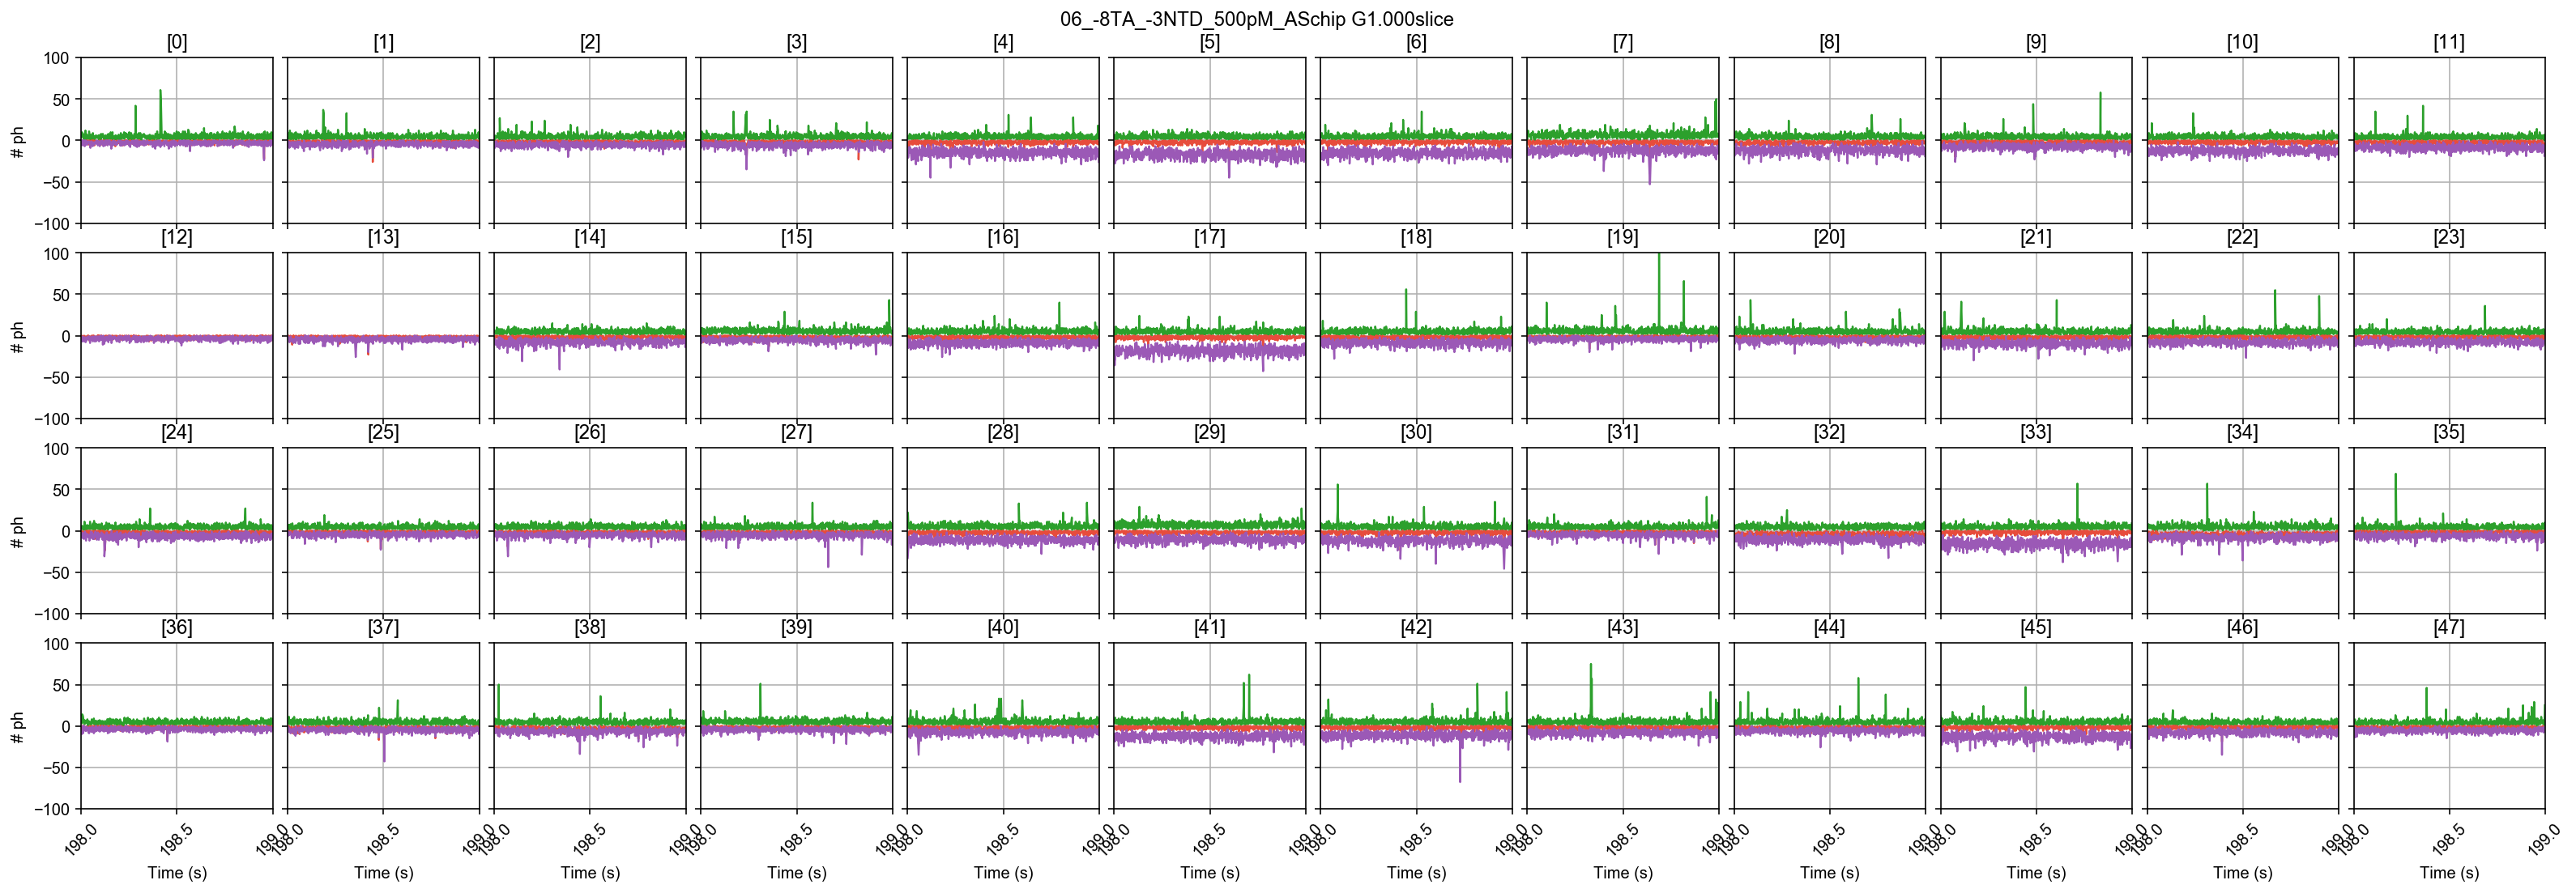

In [21]:
if plot_timetraces:
    num_time_points = 5
    kws = dict(figsize=(24, 8), xrotation=45)
    
    # Timepoints equally distributed along the measurement
    time_points = np.round(np.linspace(d0.time_min+1, d0.time_max-2, num=num_time_points))

    for i in time_points:
        dplot(d0, timetrace, tmin=i, tmax=i+1, **kws)
        plt.ylim(-100, 100)
        plt.savefig(f'{save_dir}/no_flow_timetrace={i}-{i+1}.png', dpi=1200)
        dplot(d1, timetrace, tmin=i, tmax=i+1, **kws)
        plt.ylim(-100, 100)
        plt.savefig(f'{save_dir}/Streets_chip_with_flow_timetrace={i}-{i+1}.png', dpi=1200);

# Background

In [22]:
d0.calc_bg(bg.exp_fit, time_s=10, tail_min_us='auto', F_bg=1)
d1.calc_bg(bg.exp_fit, time_s=10, tail_min_us='auto', F_bg=1)

 - Calculating BG rates ... [DONE]
 - Calculating BG rates ... [DONE]


## Plot interphoton delays

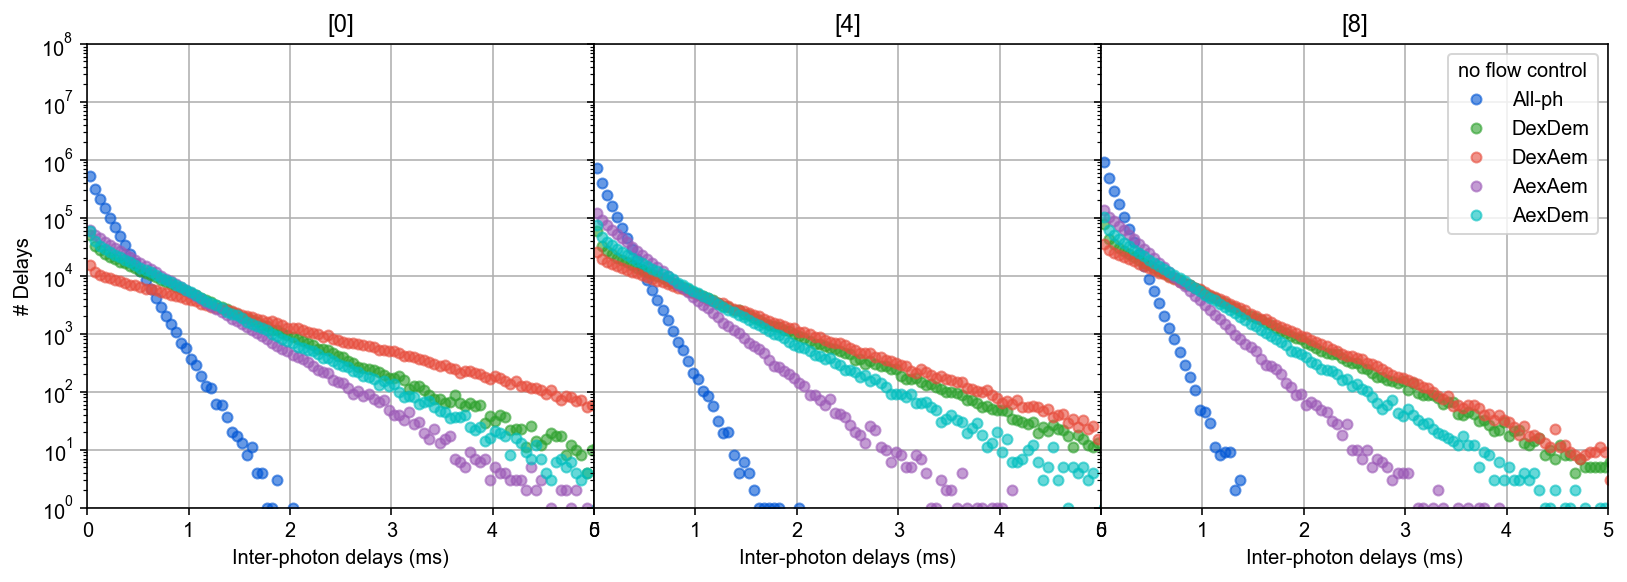

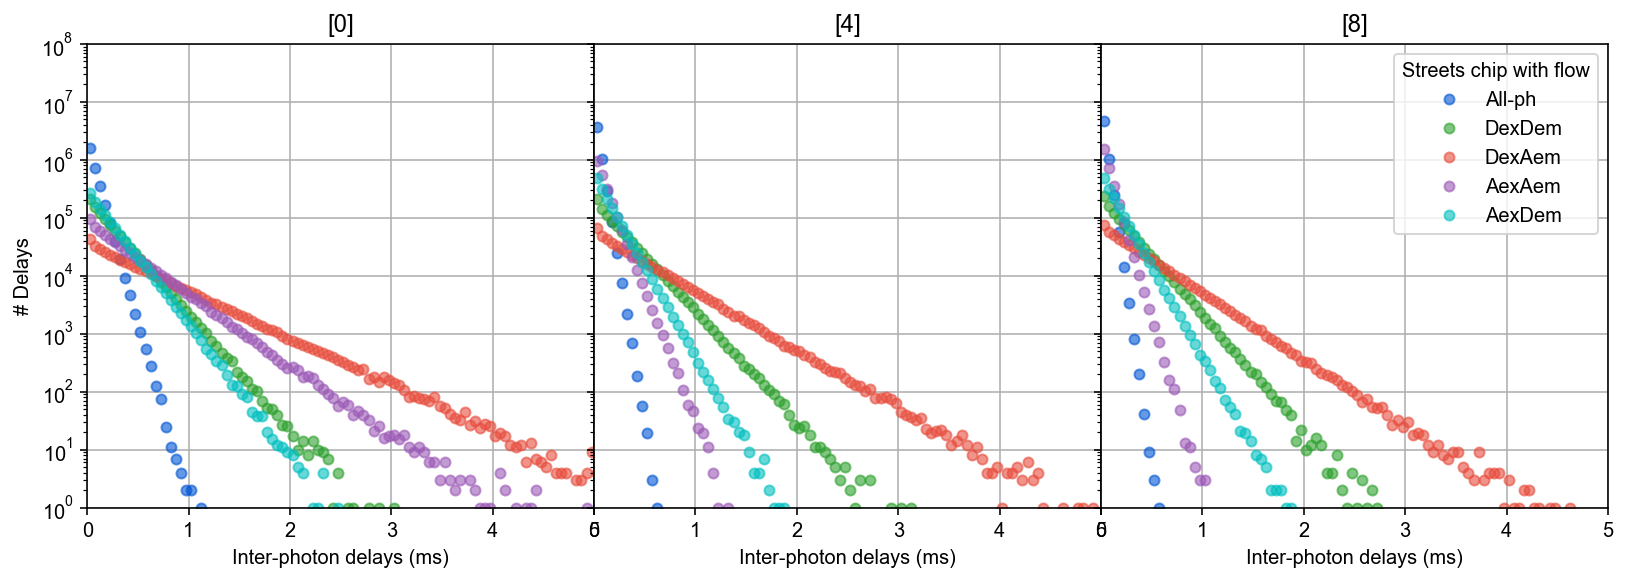

In [23]:
dplot(d0, hist_interphoton, binwidth=50e-6, show_da=True, dec=4, 
      suptitle=False, wspace=0, figsize=(12, 4), legend=True)
plt.xlim(50e-6, 5)
plt.ylim(1, 1e8)
plt.legend(title='no flow control')

dplot(d1, hist_interphoton, binwidth=50e-6, show_da=True, dec=4, 
      suptitle=False, wspace=0, figsize=(12, 4), legend=True)
plt.xlim(50e-6, 5)
plt.ylim(1, 1e8)
plt.legend(title='Streets chip with flow');

In [ ]:
def _normalize_kwargs(kwargs, kind='patch'):
    """Convert matplotlib keywords from short to long form."""
    if kwargs is None:
        return {}

    if kind == 'line2d':
        long_names = dict(c='color', ls='linestyle', lw='linewidth',
                          mec='markeredgecolor', mew='markeredgewidth',
                          mfc='markerfacecolor', ms='markersize',)
    elif kind == 'patch':
        long_names = dict(c='color', ls='linestyle', lw='linewidth',
                          ec='edgecolor', fc='facecolor',)
    for short_name in long_names:
        if short_name in kwargs:
            kwargs[long_names[short_name]] = kwargs.pop(short_name)
    return kwargs

In [ ]:
_ph_sel_color_dict = {Ph_sel('all'): blue, 
                      Ph_sel(Dex='Dem'): green,
                      Ph_sel(Dex='Aem'): red, 
                      Ph_sel(Aex='Aem'): purple,
                      Ph_sel(Aex='Dem'): 'c', }
_ph_sel_label_dict = {Ph_sel('all'): 'All-ph', 
                      Ph_sel(Dex='Dem'): 'DexDem',
                      Ph_sel(Dex='Aem'): 'DexAem', 
                      Ph_sel(Aex='Aem'): 'AexAem',
                      Ph_sel(Aex='Dem'): 'AexDem'}

In [ ]:
def hist_interphoton_single(d0, d1, i=0, binwidth=1e-4, tmax=None, bins=None,
                            ph_sel=Ph_sel('all'), period=None,
                            yscale='log', xscale='linear', xunit='ms',
                            plot_style=None):
    
    unit_dict = {'s': 1, 'ms': 1e3, 'us': 1e6, 'ns': 1e9}
    assert xunit in unit_dict
    scalex = unit_dict[xunit]

    # Compute interphoton delays
    if period is None:
        ph0_times = d0.get_ph_times(ich=i, ph_sel=ph_sel)
        ph1_times = d1.get_ph_times(ich=i, ph_sel=ph_sel)
    else:
        ph0_times = d0.get_ph_times_period(ich=i, period=period, ph_sel=ph_sel)
        ph1_times = d1.get_ph_times_period(ich=i, period=period, ph_sel=ph_sel)
    delta_ph0_t = np.diff(ph0_times) * d0.clk_p
    delta_ph1_t = np.diff(ph1_times) * d1.clk_p
    if tmax is None:
        tmax0 = delta_ph0_t.max()
        tmax1 = delta_ph1_t.max()
        
    # Compute bin edges if not passed in
    if bins is None:
        # Shift by half clk_p to avoid "beatings" in the distribution
        # due to floating point inaccuracies.
        bins0 = np.arange(0, tmax0 + binwidth, binwidth) - 0.5 * d0.clk_p
        bins1 = np.arange(0, tmax1 + binwidth, binwidth) - 0.5 * d1.clk_p
    else:
        warnings.warn('Using `bins` and ignoring `tmax` and `binwidth`.')
    t0_ax = bins0[:-1] + 0.5 * binwidth
    t1_ax = bins1[:-1] + 0.5 * binwidth

    # Compute interphoton histogram
    counts0, _ = np.histogram(delta_ph0_t, bins=bins0)
    counts1, _ = np.histogram(delta_ph1_t, bins=bins1)

    # Max index with counts > 0
    n0_trim = np.trim_zeros(counts0).size + 1
    n1_trim = np.trim_zeros(counts1).size + 1

    # Plot histograms
    plot_style_ = dict(lw=4, alpha=0.7)
    
    #if ph_sel in _ph_sel_color_dict:
        #plot_style_['color'] = _ph_sel_color_dict[ph_sel]
        #plot_style_['label'] = _ph_sel_label_dict[ph_sel]
    
    plot_style_.update(_normalize_kwargs(plot_style, kind='line2d'))
    plot(t0_ax[:n0_trim] * scalex, counts0[:n0_trim], **plot_style_)
    plot(t1_ax[:n1_trim] * scalex, counts1[:n1_trim], **plot_style_)

    if yscale == 'log':
        gca().set_yscale(yscale)
        plt.ylim(1)
        _plot_status['hist_interphoton_single'] = {'autoscale': False}
    if xscale == 'log':
        gca().set_xscale(yscale)
        plt.xlim(0.5 * binwidth)
        _plot_status['hist_interphoton_single'] = {'autoscale': False}
    plt.xlabel('Inter-photon delays (%s)' % xunit.replace('us', 'μs'))
    plt.ylabel('# Delays')
    # Return internal variables so that other functions can extend the plot
    return dict(counts0=counts0, counts1=counts1, n0_trim=n0_trim, n1_trim=n1_trim, plot_style_=plot_style_,
                t0_ax=t0_ax, t1_ax=t1_ax, scalex=scalex)

In [ ]:
def hist_interphoton(d0, d1, i=0, binwidth=1e-4, tmax=None, bins=None, period=None,
                     yscale='log', xscale='linear', xunit='ms', plot_style=None,
                     show_da=False, legend=True):
   
    # Plot multiple timetraces
    ph_sel_list = [Ph_sel('all'), Ph_sel(Dex='Dem'), Ph_sel(Dex='Aem')]
    if d0.alternated:
        ph_sel_list.append(Ph_sel(Aex='Aem'))
        if show_da:
            ph_sel_list.append(Ph_sel(Aex='Dem'))

    for ix, ph_sel in enumerate(ph_sel_list):
        if not bl.mask_empty(d0.get_ph_mask(i, ph_sel=ph_sel)):
            hist_interphoton_single(d0, d1, i=i, binwidth=binwidth, tmax=None, bins=None, 
                                    period=period, ph_sel=ph_sel,
                                    yscale=yscale, xscale=xscale, xunit=xunit,
                                    plot_style=plot_style)
            
            
            
    if legend:
        plt.legend(loc='best')

    if yscale == 'log' or xscale == 'log':
        _plot_status['hist_interphoton'] = {'autoscale': False}


In [ ]:
legend_list = ['All-ph: no flow', 'All-ph: Streets chip with flow', 'DexDem: no flow', 
               'DexDem: Streets chip with flow', 'DexAem: no flow', 'DexAem: Streets chip with flow',
              'AexAem: no flow', 'AexAem: Streets chip with flow']

No handles with labels found to put in legend.


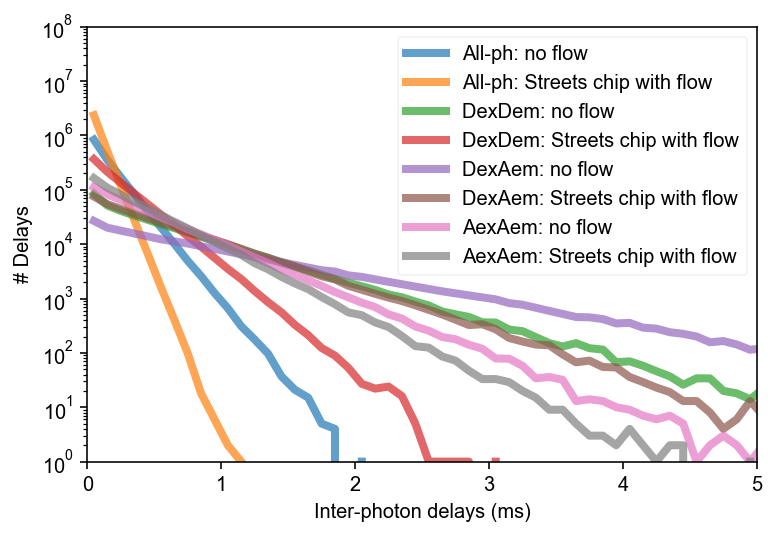

In [ ]:
hist_interphoton(d0, d1, i=0, binwidth=1e-4, tmax=None, bins=None, period=None,
                     yscale='log', xscale='linear', xunit='ms', plot_style=None,
                     show_da=False)
plt.xlim(50e-6, 5)
plt.ylim(1, 1e8)
plt.legend(legend_list, framealpha=0.2)
plt.savefig(f'{save_dir}/{mlabels[0]}_{mlabels[1]}_interphoton_delay_distribution_nt.png', bbox_to_anchor='tight', dpi = 1200);

## Plot background rates

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will 

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will 

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will 

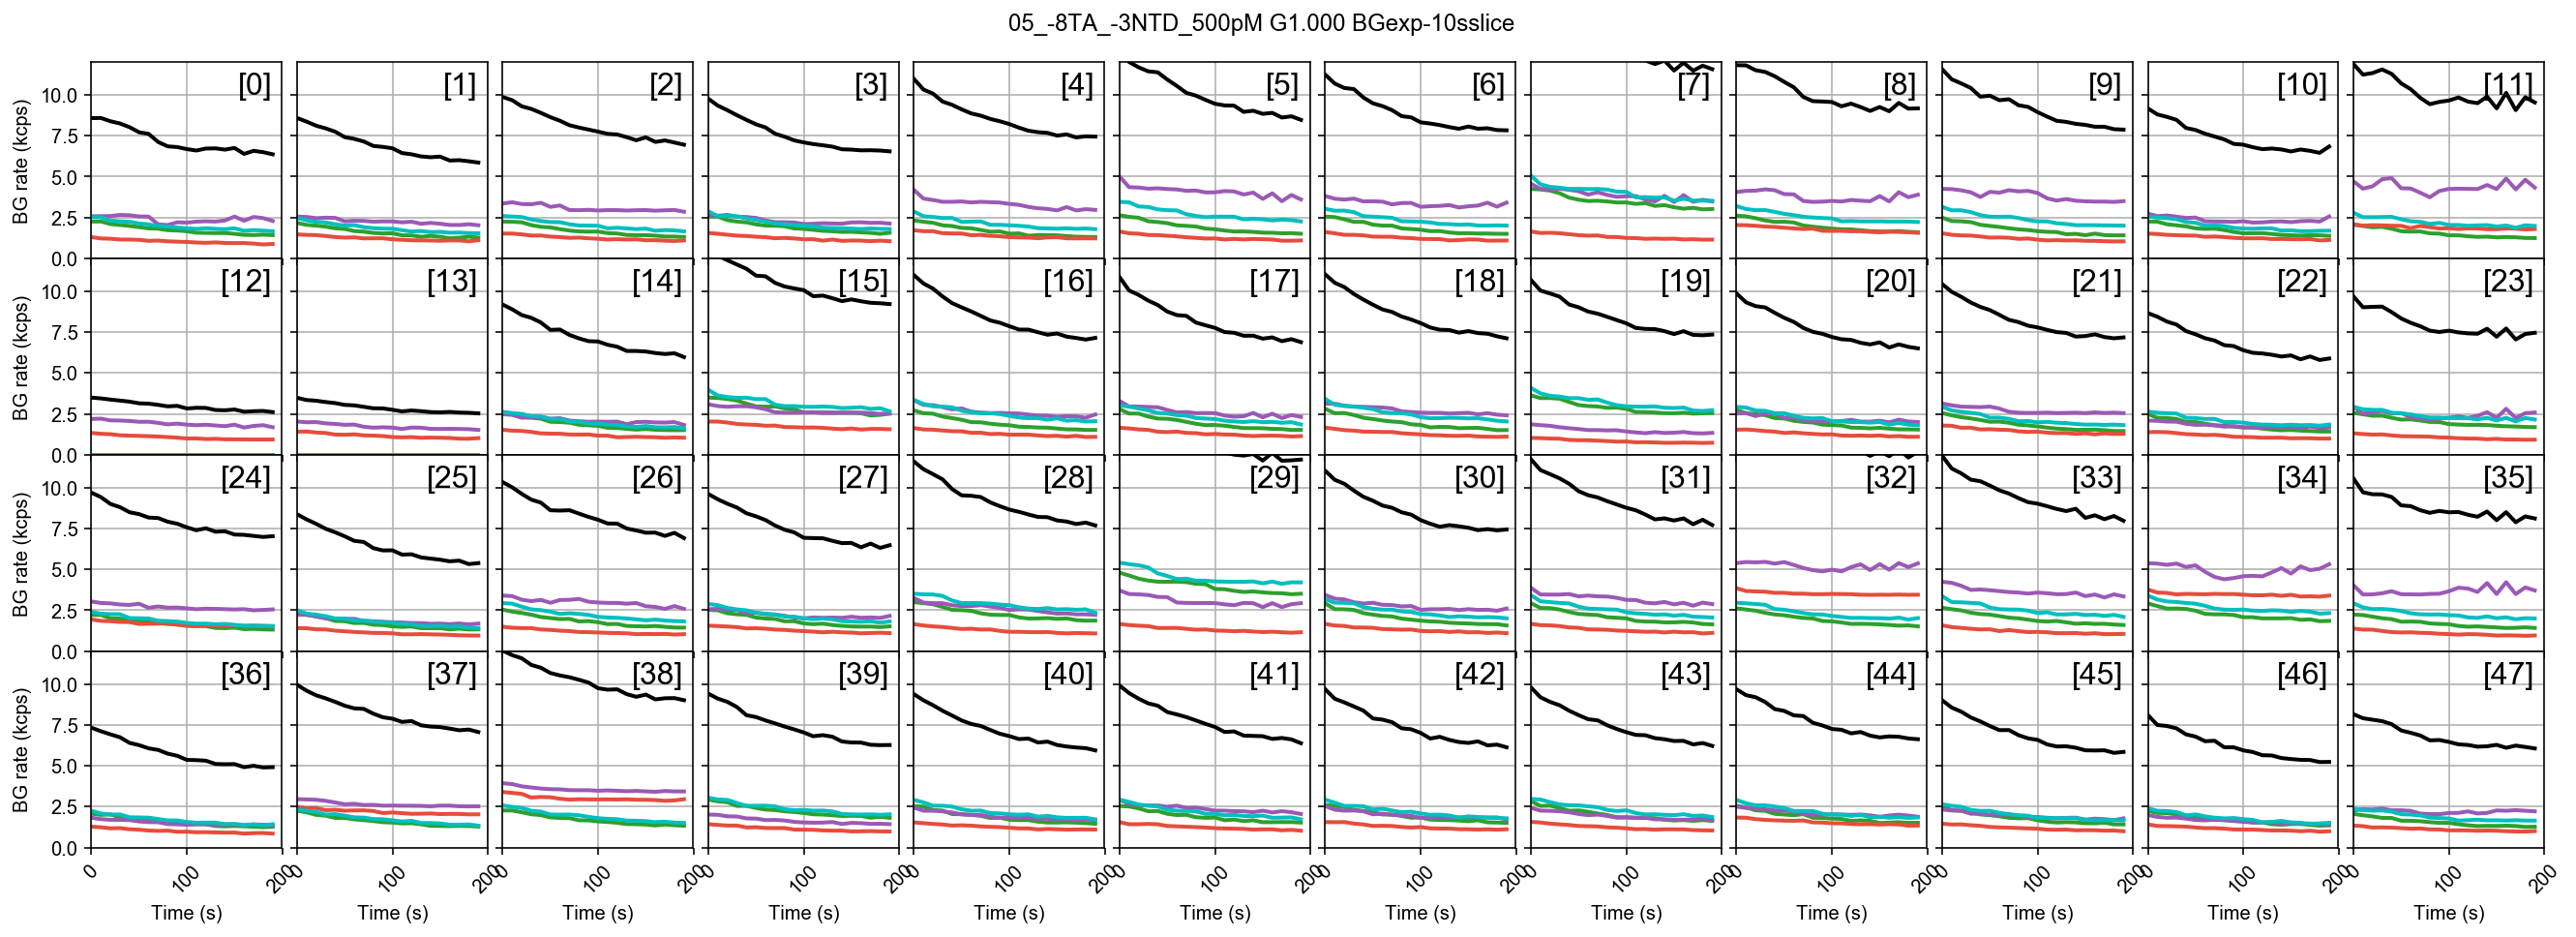

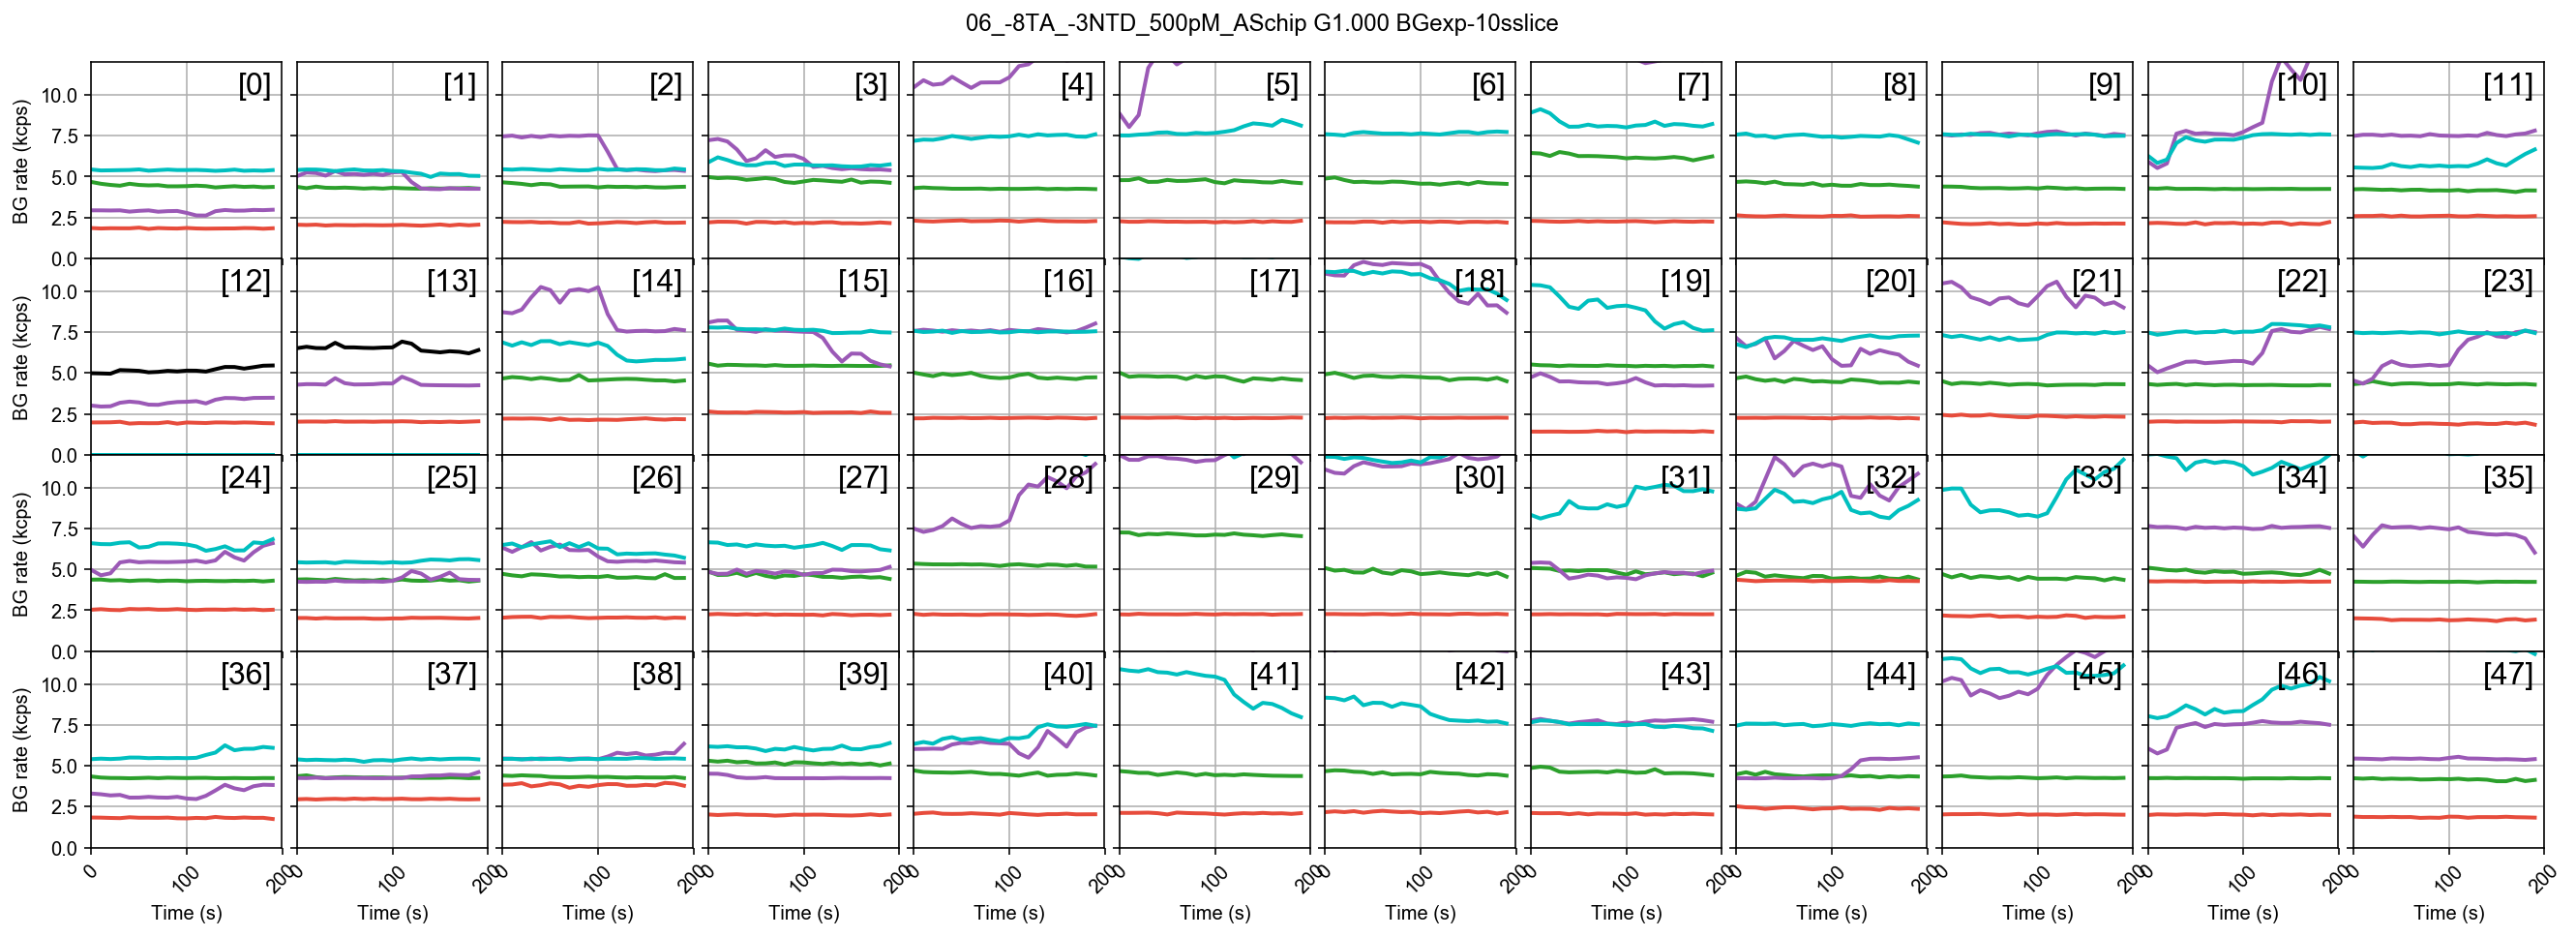

In [ ]:
ax = dplot(d0, timetrace_bg, show_da=True, hspace=0, wspace=0.08,
           plot_style=dict(marker=None), title='right top', 
           title_kws=dict(fontsize=16), xrotation=45)
plt.xlim(0)
plt.ylim(0, 12)
plt.savefig(f'{save_dir}/{mlabels[0]}_background_48-spots_all_streams.png', bbox_to_anchor='tight', dpi = 1200)

ax = dplot(d1, timetrace_bg, show_da=True, hspace=0, wspace=0.08,
           plot_style=dict(marker=None), title='right top', 
           title_kws=dict(fontsize=16), xrotation=45)
plt.xlim(0)
plt.ylim(0, 12)
plt.savefig(f'{save_dir}/{mlabels[1]}_background_48-spots_all_streams.png', bbox_to_anchor='tight', dpi = 1200);

In [ ]:
bg_AexDem_0 = d0.bg_from(Ph_sel(Aex='Dem'))
bg_AexAem_0 = d0.bg_from(Ph_sel(Aex='Aem'))
bg_DexDem_0 = d0.bg_from(Ph_sel(Dex='Dem'))
bg_DexAem_0 = d0.bg_from(Ph_sel(Dex='Aem'))

bg_AexDem_1 = d1.bg_from(Ph_sel(Aex='Dem'))
bg_AexAem_1 = d1.bg_from(Ph_sel(Aex='Aem'))
bg_DexDem_1 = d1.bg_from(Ph_sel(Dex='Dem'))
bg_DexAem_1 = d1.bg_from(Ph_sel(Dex='Aem'))

In [ ]:
import matplotlib.patches as mpatches

In [ ]:
green_patch = mpatches.Patch(color=green, label='no flow')
red_patch = mpatches.Patch(color=red, label='no flow')
blue_patch = mpatches.Patch(color=blue, label='flow rate = 10μL/hr')
purple_patch = mpatches.Patch(color=purple, label='flow rate = 10μL/hr')

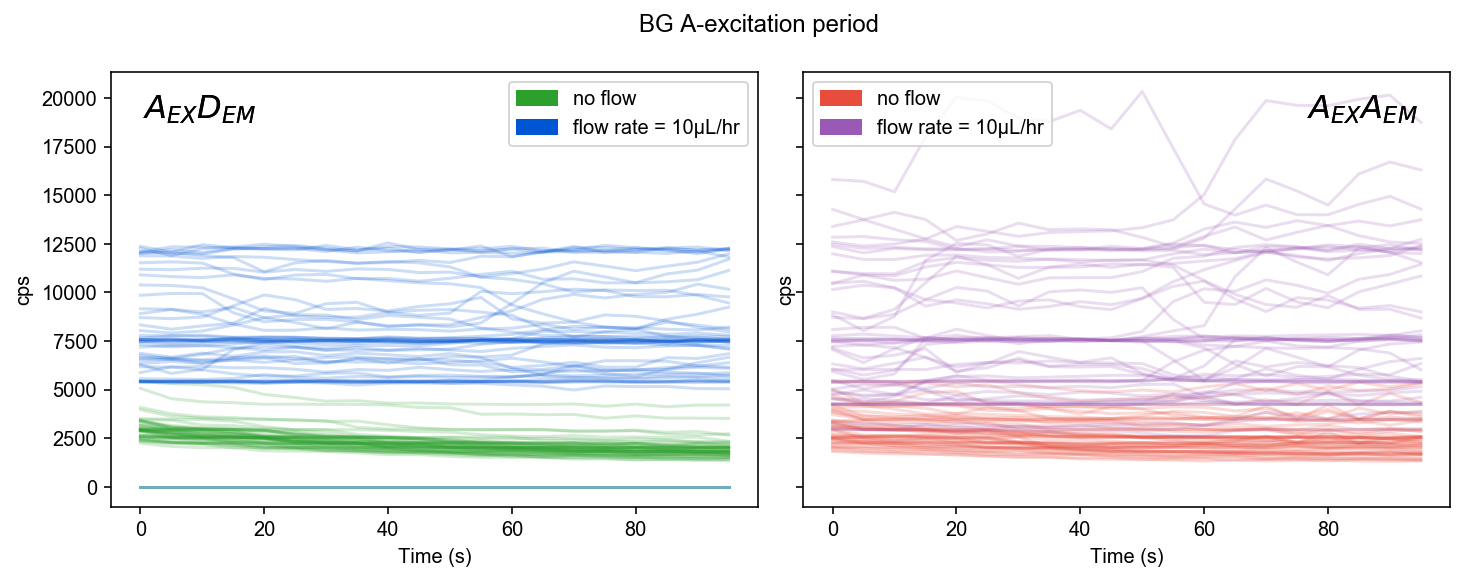

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
fig.suptitle("BG A-excitation period")
t0 = np.arange(len(bg_AexDem_0[0])) * 5
t1 = np.arange(len(bg_AexDem_1[0])) * 5
ax[0].plot(t0, np.array(bg_AexDem_0).T, color=green, alpha=0.2)
ax[1].plot(t0, np.array(bg_AexAem_0).T, color=red, alpha=0.2)
ax[0].plot(t1, np.array(bg_AexDem_1).T, color=blue, alpha=0.2)
ax[1].plot(t1, np.array(bg_AexAem_1).T, color=purple, alpha=0.2)
plt.setp(ax, xlabel='Time (s)', ylabel='cps')
plt.subplots_adjust(wspace=0.07)
ax[0].text(0.05, 0.95, '$A_{EX}D_{EM}$', va='top', fontsize=16, transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, '$A_{EX}A_{EM}$', va='top', ha='right', fontsize=16, transform=ax[1].transAxes)
ax[0].text(0.05, 0.95, '$A_{EX}D_{EM}$', va='top', fontsize=16, transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, '$A_{EX}A_{EM}$', va='top', ha='right', fontsize=16, transform=ax[1].transAxes)
ax[0].legend(handles=[green_patch, blue_patch], loc='upper right')
ax[1].legend(handles=[red_patch, purple_patch], loc='upper left')
plt.savefig(f'{save_dir}/{mlabels[0]}_{mlabels[1]}_background_AexDem_AexAem.png', bbox_to_anchor='tight', dpi = 1200);

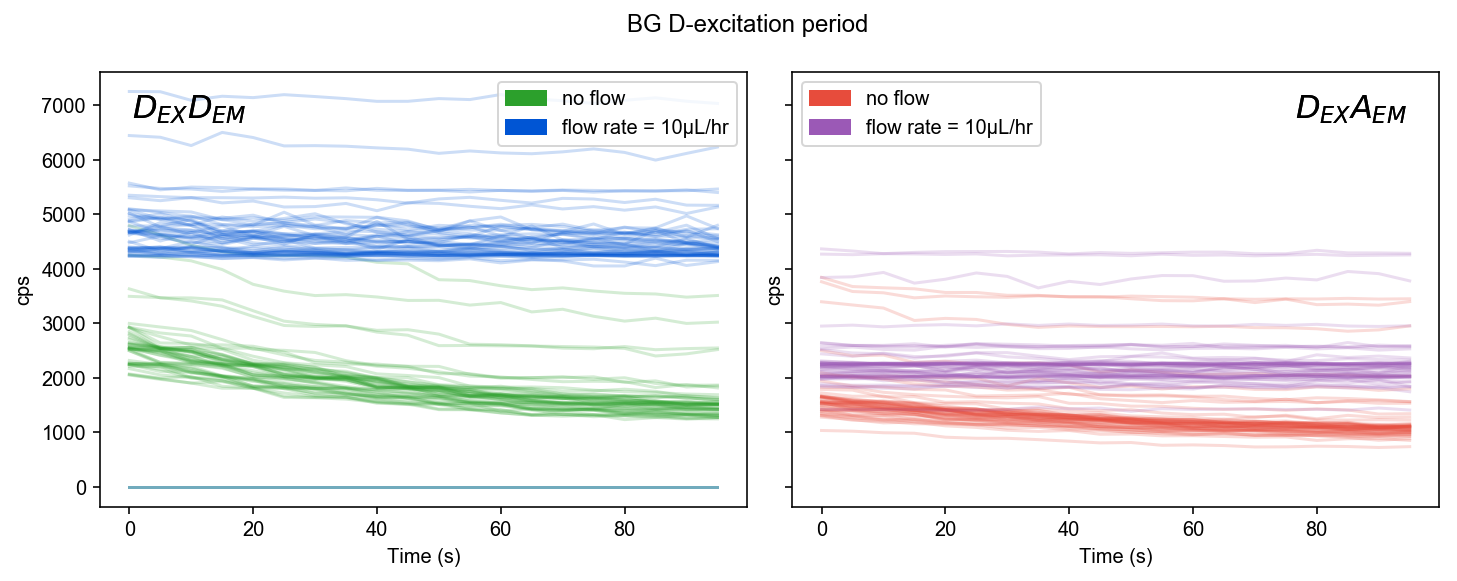

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
fig.suptitle("BG D-excitation period")
t0 = np.arange(len(bg_DexDem_0[0])) * 5
t1 = np.arange(len(bg_DexDem_1[0])) * 5
ax[0].plot(t0, np.array(bg_DexDem_0).T, color=green, alpha=0.2)
ax[1].plot(t0, np.array(bg_DexAem_0).T, color=red, alpha=0.2)
ax[0].plot(t1, np.array(bg_DexDem_1).T, color=blue, alpha=0.2)
ax[1].plot(t1, np.array(bg_DexAem_1).T, color=purple, alpha=0.2)
plt.setp(ax, xlabel='Time (s)', ylabel='cps')
plt.subplots_adjust(wspace=0.07)
ax[0].text(0.05, 0.95, '$D_{EX}D_{EM}$', va='top', fontsize=16, transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, '$D_{EX}A_{EM}$', va='top', ha='right', fontsize=16, transform=ax[1].transAxes)
ax[0].text(0.05, 0.95, '$D_{EX}D_{EM}$', va='top', fontsize=16, transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, '$D_{EX}A_{EM}$', va='top', ha='right', fontsize=16, transform=ax[1].transAxes)
ax[0].legend(handles=[green_patch, blue_patch], loc='upper right')
ax[1].legend(handles=[red_patch, purple_patch], loc='upper left')
plt.savefig(f'{save_dir}/{mlabels[0]}_{mlabels[1]}_background_DexDem_DexAem.png', bbox_to_anchor='tight', dpi = 1200);

# Burst searches

In order to compare the control measurement without flow to the measurement acquired with the Streets chip under flow conditions, it is necessary to test the effect of different burst searches. Two burst searches will be tested, where only one parameter is changed:
1. Burst search using a fixed threshold
2. Burst search using a moving threshold

In [ ]:
Dex0 = d0.setup['excitation_input_powers'][0] * 1e3
Dex1 = d1.setup['excitation_input_powers'][0] * 1e3
Aex0 = d0.setup['excitation_input_powers'][1] * 1e3
Aex1 = d1.setup['excitation_input_powers'][1] * 1e3
power0 = f'D{Dex0:.0f}mW_A{Aex0:.0f}mW'
power1 = f'D{Dex1:.0f}mW_A{Aex1:.0f}mW'
power0, power1 

('D300mW_A600mW', 'D500mW_A800mW')

In [ ]:
Dex_ratio = 300 / 500 # [mW]
Aex_ratio = 600 / 800 # [mW]
Dex_ratio, Aex_ratio

(0.6, 0.75)

In [ ]:
cps_ratio = np.mean((50e3 / Dex_ratio, 50e3 / Aex_ratio))
cps_ratio

75000.0

**Compare burst search results for two cases**

1. Different constant thresholds 
    - no flow control, th=50,000cps
    - Streets chip with flow, th=75,000cps i.e. scaled by `cps_ratio`

2. Equal moving threshold 
    - no flow control, F=6
    - Streets chip with flow, F=6

In [ ]:
bsearch_params_constant0 = dict(m=10, ph_sel=Ph_sel('all'), pax=True, min_rate_cps=50_000) 
bsearch_params_constant1 = dict(m=10, ph_sel=Ph_sel('all'), pax=True, min_rate_cps=75_000)
bsearch_params_moving = dict(m=10, ph_sel=Ph_sel('all'), pax=True, F=6)

In [ ]:
d2 = d0.copy()
d3 = d1.copy()

Deep copy executed.
Deep copy executed.


In [ ]:
d0.burst_search(**bsearch_params_constant0) 
d1.burst_search(**bsearch_params_constant1) 
d2.burst_search(**bsearch_params_moving) 
d3.burst_search(**bsearch_params_moving) 

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]


In [ ]:
d0.calc_max_rate(m=bsearch_params_constant0['m'])
d1.calc_max_rate(m=bsearch_params_constant1['m'])
d2.calc_max_rate(m=bsearch_params_moving['m'])
d3.calc_max_rate(m=bsearch_params_moving['m'])

# Save burst search results to CSV

Burst search results are loaded into a DataFrame and saved as .CSV

In [ ]:
Path('results/').mkdir(exist_ok=True)

## Save 48-spot burst results

In [ ]:
fname_bursts_50kcps = f'results/{f0}_bsearch_params'
for k, v in bsearch_params_constant0.items():
    fname_bursts_50kcps += f'_{k}_{v}'
fname_bursts_50kcps

In [ ]:
fname_bursts_75kcps = f'results/{f1}_bsearch_params'
for k, v in bsearch_params_constant1.items():
    fname_bursts_75kcps += f'_{k}_{v}'
fname_bursts_75kcps

In [ ]:
fname_bursts_F6_0 = f'results/{f0}_bsearch_params'
for k, v in bsearch_params_moving.items():
    fname_bursts_F6_0 += f'_{k}_{v}'
fname_bursts_F6_0

In [ ]:
fname_bursts_F6_1 = f'results/{f1}_bsearch_params'
for k, v in bsearch_params_moving.items():
    fname_bursts_F6_1 += f'_{k}_{v}'
fname_bursts_F6_1

In [ ]:
bursts_m10_50kcps = bext.burst_data(d0, include_bg=False)
bursts_m10_75kcps = bext.burst_data(d1, include_bg=False)
bursts_m10_F6_0 = bext.burst_data(d2, include_bg=False)
bursts_m10_F6_1 = bext.burst_data(d3, include_bg=False)

In [ ]:
bursts_m10_50kcps.to_csv(fname_bursts_50kcps + '.csv')
bursts_m10_75kcps.to_csv(fname_bursts_75kcps + '.csv')
bursts_m10_F6_0.to_csv(fname_bursts_F6_0 + '.csv')
bursts_m10_F6_1.to_csv(fname_bursts_F6_1 + '.csv')

In [ ]:
pd.read_csv(fname_bursts_50kcps + '.csv', index_col=0).head()

In [ ]:
pd.read_csv(fname_bursts_75kcps + '.csv', index_col=0).head()

In [ ]:
pd.read_csv(fname_bursts_F6_0 + '.csv', index_col=0).head()

In [ ]:
pd.read_csv(fname_bursts_F6_1 + '.csv', index_col=0).head()

# Burst selection

In [ ]:
size_th = 50
size_sel_kws = dict(ph_sel=Ph_sel(Dex='DAem', Aex='DAem'), gamma=1,
                    na_comp=False, naa_comp=False, naa_aexonly=False)
Math(d0._burst_sizes_pax_formula(**size_sel_kws))

In [ ]:
size_Dex = 20
size_sel_kws = dict(ph_sel=Ph_sel(Dex='DAem', Aex='Dem'), gamma=0.5,
                    na_comp=True, naa_comp=False, naa_aexonly=False)
Math(d0._burst_sizes_pax_formula(**size_sel_kws))

In [ ]:
naa_sel_kws = dict(ph_sel=Ph_sel(Aex='Aem'), gamma=1,
                   na_comp=False, naa_comp=False, naa_aexonly=False)
Math(d0._burst_sizes_pax_formula(**naa_sel_kws))

In [ ]:
size_Aex = 10
naa_sel_kws = dict(ph_sel=Ph_sel(Aex='Aem'), gamma=0.5,
                   na_comp=False, naa_comp=False, naa_aexonly=False)

Math(d0._burst_sizes_pax_formula(**naa_sel_kws))

Two size selections for isolation of the FRET population using ACBS.

In [ ]:
ds2 = d2.select_bursts(select_bursts.size, th1=size_Dex, **size_sel_kws)
Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(ds2.nd, ds2.na, ds2.naa)]
ds2.add(Su=Su)
dss2 = ds2.select_bursts(select_bursts.size, th1=size_Aex, **naa_sel_kws)
Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(dss2.nd, dss2.na, dss2.naa)]
dss2.add(Su=Su)

In [ ]:
ds3 = d3.select_bursts(select_bursts.size, th1=size_Dex, **size_sel_kws)
Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(ds3.nd, ds3.na, ds3.naa)]
ds3.add(Su=Su)
dss3 = ds3.select_bursts(select_bursts.size, th1=size_Aex, **naa_sel_kws)
Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(dss3.nd, dss3.na, dss3.naa)]
dss3.add(Su=Su)

In [ ]:
ds2_th1 = ds2.select_bursts(select_bursts.size, th1=size_Dex, **naa_sel_kws)
ds2_th2 = ds2_th1.select_bursts(select_bursts.size, th1=size_th, **size_sel_kws)
dcs2_th = ds2_th2.collapse(update_gamma=False)

ds3_th1 = ds3.select_bursts(select_bursts.size, th1=size_Dex, **naa_sel_kws)
ds3_th2 = ds3_th1.select_bursts(select_bursts.size, th1=size_th, **size_sel_kws)
dcs3_th = ds3_th2.collapse(update_gamma=False)

# Heatmaps

In [ ]:
bs_mean_2 = []
bs_mean_3 = []

for i in range(48):
    sizes_ch = d2.burst_sizes_pax_ich(i, **size_sel_kws) 
    tail = sizes_ch > size_th
    bs_mean_2.append(sizes_ch[tail].mean() - size_th)
    
for i in range(48):
    sizes_ch = d3.burst_sizes_pax_ich(i, **size_sel_kws) 
    tail = sizes_ch > size_th
    bs_mean_3.append(sizes_ch[tail].mean() - size_th)

In [ ]:
bs_median_2 = np.int(np.around(np.median(bs_mean_2)))
bs_median_3 = np.int(np.around(np.median(bs_mean_3)))
bs_mean_mean_2 = np.int(np.around(np.mean(bs_mean_2)))
bs_mean_mean_3 = np.int(np.around(np.mean(bs_mean_3)))


heatmap48(bs_mean_2, cmap='viridis', 
          title=f'Mean Burst Sizes, D-SPAD \n no flow control \n mean burst size = {bs_mean_mean_2} photons \n median burst size= {bs_median_2} photons')
#savefig('heatmap_burst_sizes')

heatmap48(bs_mean_3, cmap='viridis', 
          title=f"Mean Burst Sizes, A-SPAD \n Streets chip, flow rate = 10μL/hr \n mean burst size = {bs_mean_mean_3} photons \n median burst size = {bs_median_3} photons")
#savefig(f'heatmap_burst_sizes_{mlabel[1]}')

In [ ]:
bw_mean_2 = []
bw_mean_3 = []
width_th = 0.4

for i in range(48):
    widths_ch = d2.mburst[i].width * d2.clk_p * 1e3
    tail = widths_ch > width_th
    bw_mean_2.append(widths_ch[tail].mean() - width_th)
    
for i in range(48):
    widths_ch = d3.mburst[i].width * d3.clk_p * 1e3
    tail = widths_ch > width_th
    bw_mean_3.append(widths_ch[tail].mean() - width_th)

In [ ]:
bw_median_2 = np.around(np.median(bw_mean_2), 2)
bw_median_3 = np.around(np.median(bw_mean_3), 2)
bw_mean_mean_2 = np.around(np.mean(bw_mean_2), 2)
bw_mean_mean_3 = np.around(np.mean(bw_mean_3), 2)

heatmap48(bw_mean_2, cmap='viridis',
          title=f"Mean Burst Width, D-SPAD \n no flow control \n mean burst width = {bw_mean_mean_2} ms \n median burst width = {bw_median_2} ms")
#savefig('heatmap_burst_widths')

heatmap48(bw_mean_3, cmap='viridis',
          title=f"Mean Burst Width, A-SPAD \n Streets chip, flow rate = 10μL/hr \n mean burst width = {bw_mean_mean_3} ms \n median burst width = {bw_median_3} ms")
#savefig('heatmap_burst_widths')

# $E_{PR}-S_u$ histograms

In [ ]:
ax = dplot(ds2, hexbin_alex, S_name='Su', vmax=15, 
           wspace=0, hspace=0, gridsize=60, title='bottom left', title_bg=False);
ax0 = ax[0, 0]
fig = ax0.figure
cax = fig.add_axes([0.97, 0.25, 0.01, 0.5])
plt.setp(ax[:, 0], ylabel='$S_u$');
plt.setp(ax[-1], xlabel='$E_{PR}$');
plt.colorbar(cax=cax)
ax0.set_xticks([0, 0.5, 1])
ax0.set_yticks([0, 0.5, 1]);
ax0.set_xlim(-0.2, 1)
ax0.set_ylim(0, 1.2);
plt.savefig(f'{save_dir}/{mlabels[0]}_Dex_th-20_sel_alex_hist_Su_size_48spot_all-bursts_F6.png', 
            bbox_to_anchor='tight', dpi = 1200);

In [ ]:
ax = dplot(ds3, hexbin_alex, S_name='Su', vmax=15, 
           wspace=0, hspace=0, gridsize=60, title='bottom left', title_bg=False);
ax0 = ax[0, 0]
fig = ax0.figure
cax = fig.add_axes([0.97, 0.25, 0.01, 0.5])
plt.setp(ax[:, 0], ylabel='$S_u$');
plt.setp(ax[-1], xlabel='$E_{PR}$');
plt.colorbar(cax=cax)
ax0.set_xticks([0, 0.5, 1])
ax0.set_yticks([0, 0.5, 1])
ax0.set_xlim(-0.2, 1)
plt.savefig(f'{save_dir}/{mlabels[1]}_Dex_th-20_Aex_th-10_sel_alex_hist_Su_size_48spot_all-bursts_F6.png', 
            bbox_to_anchor='tight', dpi = 1200);

In [ ]:
g = alex_jointplot(ds2, i=30, vmax=35, S_name='Su')
g.ax_joint.set_ylabel('$S_u$')
plt.savefig(f'{save_dir}/{mlabels[0]}_Dex_th-20_sel_alex_hist_Su_size_48spot_all-bursts_F6.png', 
            bbox_to_anchor='tight', dpi = 1200)
g = alex_jointplot(ds3, i=30, vmax=35, S_name='Su')
g.ax_joint.set_ylabel('$S_u$')
plt.savefig(f'{save_dir}/{mlabels[1]}_Dex_th-20_sel_alex_hist_Su_size_48spot_all-bursts_F6.png', 
            bbox_to_anchor='tight', dpi = 1200)
g = alex_jointplot(dss2, i=30, vmax=35, S_name='Su')
g.ax_joint.set_ylabel('$S_u$')
plt.savefig(f'{save_dir}/{mlabels[0]}_Dex_th-20_Aex_th-10_sel_alex_hist_Su_size_48spot_all-bursts_F6.png', 
            bbox_to_anchor='tight', dpi = 1200)
g = alex_jointplot(dss3, i=30, vmax=35, S_name='Su')
g.ax_joint.set_ylabel('$S_u$')
plt.savefig(f'{save_dir}/{mlabels[1]}_Dex_th-20_Aex_th-10_sel_alex_hist_Su_size_48spot_all-bursts_F6.png', 
            bbox_to_anchor='tight', dpi = 1200);

# Collapse

Pooling data from all 48 spots

In [ ]:
df2 = d2.fuse_bursts(ms=0)
df3 = d3.fuse_bursts(ms=0)

In [ ]:
dc2 = d2.collapse(update_gamma=False)
dc3 = d3.collapse(update_gamma=False)

In [ ]:
## check that chi_ch is set to 1 here
dc2.chi_ch, dc3.chi_ch

In [ ]:
d2.num_bursts.sum(), d3.num_bursts.sum()

In [ ]:
np.int(d3.num_bursts.sum() / d2.num_bursts.sum())

In [ ]:
def sel_raw_naa(d, ich=0, th1=20, th2=np.inf, gamma=1., beta=1., donor_ref=True):
    assert th1 <= th2, 'th1 (%.2f) must be <= of th2 (%.2f)' % (th1, th2)
    kws = dict(ich=ich, gamma=gamma, beta=beta, donor_ref=donor_ref)
    naa_term = d.naa[ich]
    bursts_mask = (naa_term >= th1) * (naa_term <= th2)
    return bursts_mask, ''

def sel_ndex_na(d, ich=0, th1=20, th2=np.inf, gamma=1):
    assert th1 <= th2, 'th1 (%.2f) must be <= of th2 (%.2f)' % (th1, th2)
    size = d.nd[ich] + d.nda[ich] + d.na[ich] / gamma
    bursts_mask = (size >= th1) * (size <= th2)
    return bursts_mask, ''

In [ ]:
size_sel_kws = dict(ph_sel=Ph_sel(Dex='DAem', Aex='Dem'), gamma=0.5,
                    na_comp=True, naa_comp=False, naa_aexonly=False)

Math(d0._burst_sizes_pax_formula(**size_sel_kws))

In [ ]:
naa_sel_kws = dict(ph_sel=Ph_sel(Aex='Aem'), gamma=1,
                   na_comp=False, naa_comp=False, naa_aexonly=False)

Math(d0._burst_sizes_pax_formula(**naa_sel_kws))

In [ ]:
dcs2_th1 = d2.select_bursts(select_bursts.size, th1=10, **naa_sel_kws)
dcs2_th2 = dcs2_th1.select_bursts(select_bursts.size, th1=20, **size_sel_kws)
dcs2_th = dcs2_th2.collapse(update_gamma=False)

dcs3_th1 = d3.select_bursts(select_bursts.size, th1=10, **naa_sel_kws)
dcs3_th2 = dcs3_th1.select_bursts(select_bursts.size, th1=20, **size_sel_kws)
dcs3_th = dcs3_th2.collapse(update_gamma=False)

In [ ]:
Th = (10, 20, 40, 80)
Th_naa = np.array((0, 10, 20, 40)) 
fig, AX = plt.subplots(len(Th), len(Th_naa), figsize=(3.5*len(Th_naa), 3.5*len(Th)), sharex=True, sharey=True)
for irow, th in enumerate(Th):
    for icol, th_naa in enumerate(Th_naa):
        ax = AX[irow,icol]
        dcs2_th1 = d2.select_bursts(select_bursts.size, th1=th_naa, **naa_sel_kws)
        dcs2_th2 = dcs2_th1.select_bursts(select_bursts.size, th1=th, **size_sel_kws)
        dcs2_th = dcs2_th2.collapse(update_gamma=False)
        Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(dcs2_th.nd, dcs2_th.na, dcs2_th.naa)]
        dcs2_th.add(Su=Su)
        E = dcs2_th.E[0]
        E_std = E[E > 0.2].std()
        dplot(dcs2_th, hexbin_alex, S_name='Su', gridsize=60, ax=ax)
        ax.text(0.05, 0.05, '$th_D$ = %d, $th_A$ = %d, σ = %.3f\n#B = %d' % (th, th_naa, E_std, dcs2_th.num_bursts), 
                va='bottom', ha='left', transform=ax.transAxes, fontsize=12)
        ax.set_title('')
plt.setp(AX[:-1], xlabel='')
plt.setp(AX[:, 1:], ylabel='')
plt.subplots_adjust(hspace=0, wspace=0)
plt.text(0.5, 0.89, 'ACBS, no flow control', transform=fig.transFigure, fontsize=16)
plt.savefig(f'{save_dir}/{mlabels[0]}_ACBS_matrix_alex_hist_Su_size_48spot_all-bursts_F6.png', 
            bbox_to_anchor='tight', dpi = 1200);

In [ ]:
Th = (10, 20, 40, 80)
Th_naa = np.array((0, 10, 20, 40)) 
fig, AX = plt.subplots(len(Th), len(Th_naa), figsize=(3.5*len(Th_naa), 3.5*len(Th)), sharex=True, sharey=True)
for irow, th in enumerate(Th):
    for icol, th_naa in enumerate(Th_naa):
        ax = AX[irow,icol]
        dcs3_th1 = d3.select_bursts(select_bursts.size, th1=th_naa, **naa_sel_kws)
        dcs3_th2 = dcs3_th1.select_bursts(select_bursts.size, th1=th, **size_sel_kws)
        dcs3_th = dcs3_th2.collapse(update_gamma=False)
        Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(dcs3_th.nd, dcs3_th.na, dcs3_th.naa)]
        dcs3_th.add(Su=Su)
        E = dcs3_th.E[0]
        E_std = E[E > 0.2].std()
        dplot(dcs3_th, hexbin_alex, S_name='Su', gridsize=60, ax=ax)
        ax.text(0.05, 0.05, '$th_D$ = %d, $th_A$ = %d, σ = %.3f\n#B = %d' % (th, th_naa, E_std, dcs3_th.num_bursts), 
                va='bottom', ha='left', transform=ax.transAxes, fontsize=12)
        ax.set_title('')
plt.setp(AX[:-1], xlabel='')
plt.setp(AX[:, 1:], ylabel='')
plt.subplots_adjust(hspace=0, wspace=0)
plt.text(0.5, 0.89, 'ACBS, Streets chip with flow', transform=fig.transFigure, fontsize=16)
plt.savefig(f'{save_dir}/{mlabels[1]}_ACBS_matrix_alex_hist_Su_size_48spot_all-bursts_F6.png', 
            bbox_to_anchor='tight', dpi = 1200);

In [ ]:
size_Dex = 30
size_sel_kws = dict(ph_sel=Ph_sel(Dex='DAem', Aex='Dem'), gamma=0.5,
                    na_comp=True, naa_comp=False, naa_aexonly=False)
Math(d0._burst_sizes_pax_formula(**size_sel_kws))

In [ ]:
size_Aex = 20
naa_sel_kws = dict(ph_sel=Ph_sel(Aex='Aem'), gamma=0.5,
                   na_comp=False, naa_comp=False, naa_aexonly=False)
Math(d0._burst_sizes_pax_formula(**naa_sel_kws))

In [ ]:
dcs2 = dc2.select_bursts(select_bursts.size, th1=size_Dex, **size_sel_kws)
Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(dcs2.nd, dcs2.na, dcs2.naa)]
dcs2.add(Su=Su)
dcss2 = dcs2.select_bursts(select_bursts.size, th1=size_Aex, **naa_sel_kws)
Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(dcss2.nd, dcss2.na, dcss2.naa)]
dcss2.add(Su=Su)

In [ ]:
dcs3 = dc3.select_bursts(select_bursts.size, th1=size_Dex, **size_sel_kws)
Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(dcs3.nd, dcs3.na, dcs3.naa)]
dcs3.add(Su=Su)
dcss3 = dcs3.select_bursts(select_bursts.size, th1=size_Aex, **naa_sel_kws)
Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(dcss3.nd, dcss3.na, dcss3.naa)]
dcss3.add(Su=Su)

In [ ]:
g = alex_jointplot(dcs2, S_name='Su', vmax=160, gridsize=80)
g.ax_joint.set_ylabel('$S_u$')
plt.savefig(f'{save_dir}/{mlabels[0]}_Dex_th-30_sel_vmax-160_alex_hist_Su_size_48spot_all-bursts_F6.png', 
            bbox_to_anchor='tight', dpi = 1200)
g = alex_jointplot(dcs3, S_name='Su', vmax=160, gridsize=80)
g.ax_joint.set_ylabel('$S_u$')
plt.savefig(f'{save_dir}/{mlabels[1]}_Dex_th-30_sel_vmax-160_alex_hist_Su_size_48spot_all-bursts_F6.png', 
            bbox_to_anchor='tight', dpi = 1200)
g = alex_jointplot(dcss2, S_name='Su', vmax=160, gridsize=80)
g.ax_joint.set_ylabel('$S_u$')
plt.savefig(f'{save_dir}/{mlabels[0]}_Dex_th-30_Aex_th-20_sel_vmax-160_alex_hist_Su_size_48spot_all-bursts_F6.png', 
            bbox_to_anchor='tight', dpi = 1200)
g = alex_jointplot(dcss3, S_name='Su', vmax=160, gridsize=80)
g.ax_joint.set_ylabel('$S_u$')
plt.savefig(f'{save_dir}/{mlabels[0]}_Dex_th-30_Aex_th-20_sel_vmax-160_alex_hist_Su_size_48spot_all-bursts_F6.png', 
            bbox_to_anchor='tight', dpi = 1200);


In [ ]:
g = alex_jointplot(dcs2, S_name='Su', vmax_fret=False, gridsize=80)
g.set_axis_labels(xlabel='$E$', ylabel='$S_u$')
plt.savefig(f'{save_dir}/{mlabels[0]}_Dex_th-30_sel_alex_hist_Su_size_48spot_all-bursts_F6.png', 
            bbox_to_anchor='tight', dpi = 1200)
g = alex_jointplot(dcs3, S_name='Su', vmax_fret=False, gridsize=80)
g.set_axis_labels(xlabel='$E$', ylabel='$S_u$')
plt.savefig(f'{save_dir}/{mlabels[1]}_Dex_th-30_sel_alex_hist_Su_size_48spot_all-bursts_F6.png', 
            bbox_to_anchor='tight', dpi = 1200)
g = alex_jointplot(dcss2, S_name='Su', vmax_fret=False, gridsize=80)
g.set_axis_labels(xlabel='$E$', ylabel='$S_u$')
plt.savefig(f'{save_dir}/{mlabels[0]}_Dex_th-30_Aex_th-20_sel_alex_hist_Su_size_48spot_all-bursts_F6.png', 
            bbox_to_anchor='tight', dpi = 1200)
g = alex_jointplot(dcss3, S_name='Su', vmax_fret=False, gridsize=80)
g.set_axis_labels(xlabel='$E$', ylabel='$S_u$')
plt.savefig(f'{save_dir}/{mlabels[0]}_Dex_th-30_Aex_th-20_sel_alex_hist_Su_size_48spot_all-bursts_F6.png', 
            bbox_to_anchor='tight', dpi = 1200);